In [1]:
import sys

sys.path.append("..")

In [2]:
# testing consequences of interventions on gpt2, and how they match up against our SAE's
from functools import partial

import datasets
import seaborn as sns
import torch
import torch.nn.functional as F
from einops import einsum
from IPython.core.debugger import set_trace
from safetensors.torch import load_file
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

from sae.data import chunk_and_tokenize

%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [3]:
# model_name = "gpt2"
# ckpt_path = "/home/sid/tensor-sae/checkpoints/all-layer-test/sae.safetensors"
# ckpt_path = "/home/sid/tensor-sae/checkpoints/pythia14m-all-layers-rp1t/pythia14m-all-layers-rp1t-sample_20240907_193332/layers.0_layers.1_layers.2_layers.3_layers.4_layers.5/sae-915.safetensors"
ckpt_path = "/home/sid/tensor-sae/checkpoints/pythia14m-all-layers-rp1t/pythia70m-all-layers-rp1t-sample_20240912_003009/layers.0_layers.1_layers.2_layers.3_layers.4_layers.5/sae-915.safetensors"
# ckpt_path = "/home/ubuntu/aiplay/tensor-saes/checkpoints/pythia14m-all-layers-rp1t/pythia14m-all-layers-rp1t-sample_20240908_074648/layers.0_layers.1_layers.2_layers.3_layers.4_layers.5/sae-14633.safetensors"
model_name = "EleutherAI/pythia-70m"

In [4]:
# to use jacrevd need eager implementation
model = AutoModelForCausalLM.from_pretrained(
    model_name, attn_implementation="eager"
).cuda()
tokenizer = AutoTokenizer.from_pretrained(model_name)

sae_ckpt = load_file(ckpt_path, device="cuda:0")

feature_encoder_weights = sae_ckpt.get("encoder.weight", sae_ckpt.get("weight"))
feature_encoder_bias = sae_ckpt.get("encoder.bias", sae_ckpt.get("bias"))
# legacy keys
feature_decoder_weights = sae_ckpt["decoder.weight"]
feature_decoder_bias = sae_ckpt["decoder.bias"]

intervention_index = 2
readout_index = 4


def create_hooks(
    model=None,
    intervention_index=None,
    readout_index=None,
    feature_encoder_weights=None,
    feature_encoder_bias=None,
    feature_decoder_weights=None,
    lambda_value=1.0,
    activation_rates=None,
    feature_select_k=1,
    feature_select_percentile=None,
    num_tokens=1,
    exclude_first_k_tokens=0,
    feature_indices=None,  # New parameter for specific feature indices
):
    activation_positions = None
    consequent_embeddings = None
    causal_embeddings = None
    max_feature_index = None
    # j < k in layer idx
    v_j = None
    v_k = None
    is_valid = None

    def strengthen_specific_features(module, input, output, layer_offset=0):
        nonlocal \
            activation_positions, \
            causal_embeddings, \
            v_j, \
            v_k, \
            max_feature_index, \
            is_valid

        embed_dim = output[0].shape[-1]
        feature_encoder_segment = feature_encoder_weights[
            :,
            (intervention_index - layer_offset) * embed_dim : (
                intervention_index - layer_offset + 1
            )
            * embed_dim,
        ]
        feature_decoder_segment = feature_decoder_weights[
            :,
            (intervention_index - layer_offset) * embed_dim : (
                intervention_index - layer_offset + 1
            )
            * embed_dim,
        ]

        # Encode input activations
        feature_activation = (
            einsum(output[0], feature_encoder_segment.T, "b s e, e n -> b s n")
            - feature_encoder_bias
        )

        batch_size, seq_len, _ = output[0].shape

        causal_embeddings = output[0]

        # Use the provided feature indices
        max_feature_index = feature_indices

        # Create a mask for active features
        feature_mask = torch.zeros(
            batch_size,
            seq_len,
            feature_activation.shape[-1],
            device=output[0].device,
            dtype=torch.bool,
        )
        feature_mask[:, :, feature_indices] = 1
        active_mask = ((feature_activation > 0) & feature_mask).any(dim=-1)

        # Get the decoder vectors for the specified feature indices
        selected_decoder_vectors = feature_decoder_segment[feature_indices]

        # Assign decoder vectors to v_j where features are active
        v_j = selected_decoder_vectors[None, None, :].expand(batch_size, -1, -1)

        # Get positions where selected features are activated
        activation_positions = active_mask.float()

        # Select the top k tokens with the highest activation
        _, top_k_indices = torch.topk(activation_positions, k=num_tokens, dim=-1)

        # Create a mask for the selected token positions
        token_mask = torch.zeros_like(activation_positions)
        token_mask.scatter_(1, top_k_indices, 1)

        activation_positions = top_k_indices

        new_output = output[0].clone()
        # Add lambda * v_j only to the selected token positions

        new_output += lambda_value * v_j * token_mask.unsqueeze(-1)

        intervention_decoder_segment = feature_decoder_weights[
            :,
            (readout_index - layer_offset) * embed_dim : (
                readout_index - layer_offset + 1
            )
            * embed_dim,
        ]
        v_k = intervention_decoder_segment[max_feature_index]
        # Expand v_k to match batch dimension
        v_k = v_k.unsqueeze(0).expand(batch_size, -1, -1)

        # Check if the feature fires in any of the tokens
        is_valid = (feature_activation > 0).any(dim=1).bool()

        new_outputs = [new_output] + list(output[1:])
        return tuple(new_outputs)

    def strengthen_sae_feature(module, input, output, layer_offset=0):
        nonlocal \
            activation_positions, \
            causal_embeddings, \
            v_j, \
            v_k, \
            max_feature_index, \
            is_valid

        embed_dim = output[0].shape[-1]
        feature_encoder_segment = feature_encoder_weights[
            :,
            (intervention_index - layer_offset) * embed_dim : (
                intervention_index - layer_offset + 1
            )
            * embed_dim,
        ]
        feature_decoder_segment = feature_decoder_weights[
            :,
            (intervention_index - layer_offset) * embed_dim : (
                intervention_index - layer_offset + 1
            )
            * embed_dim,
        ]

        feature_activation = (
            einsum(output[0], feature_encoder_segment.T, "b s e, e n -> b s n")
            - feature_encoder_bias
        )
        # shape (batch_size, seq_len - exclude_first_k_tokens, 1)
        feature_activation, max_feature_index = torch.kthvalue(
            feature_activation[:, exclude_first_k_tokens:, :],
            k=feature_activation.shape[-1] - feature_select_k,
            dim=-1,
        )

        activation_positions = (
            (feature_activation > 0)
            .float()
            .kthvalue(k=num_tokens, dim=1, keepdim=True)[1]
        )
        has_activation = (feature_activation > 0).any(dim=1)
        activation_positions[~has_activation] = -1

        batch_size, seq_len, embed_dim = output[0].shape

        mask = (
            torch.arange(exclude_first_k_tokens, seq_len, device=output[0].device)[
                None, None, :
            ].expand(batch_size, -1, -1)
            == activation_positions.unsqueeze(-1).expand(
                -1, -1, seq_len - exclude_first_k_tokens
            )
            + exclude_first_k_tokens
        )

        mask = mask.any(dim=1)

        causal_embeddings = output[0]

        # (batch_size, seq_len - exclude_first_k_tokens, embed_dim)
        v_j = (
            feature_decoder_segment.unsqueeze(0)
            .expand(output[0].shape[0], -1, -1)
            .gather(1, max_feature_index.unsqueeze(-1).expand(-1, -1, embed_dim))
        )
        new_output = output[0].clone()
        new_output[:, exclude_first_k_tokens:, :] += (
            lambda_value * mask[:, :, None] * v_j
        )

        intervention_decoder_segment = feature_decoder_weights[
            :,
            (readout_index - layer_offset) * embed_dim : (
                readout_index - layer_offset + 1
            )
            * embed_dim,
        ]
        v_k = (
            intervention_decoder_segment.unsqueeze(0)
            .expand(output[0].shape[0], -1, -1)
            .gather(1, max_feature_index.unsqueeze(-1).expand(-1, -1, embed_dim))
        )

        # Check if the feature fires in any of the tokens
        is_valid = (feature_activation > 0).any(dim=1).bool()

        new_outputs = [new_output] + list(output[1:])
        return tuple(new_outputs)

    def strengthen_sae_feature_with_rates(module, input, output, layer_offset=0):
        nonlocal \
            activation_positions, \
            causal_embeddings, \
            v_j, \
            v_k, \
            max_feature_index, \
            is_valid

        embed_dim = output[0].shape[-1]
        feature_encoder_segment = feature_encoder_weights[
            :,
            (intervention_index - layer_offset) * embed_dim : (
                intervention_index - layer_offset + 1
            )
            * embed_dim,
        ]
        feature_decoder_segment = feature_decoder_weights[
            :,
            (intervention_index - layer_offset) * embed_dim : (
                intervention_index - layer_offset + 1
            )
            * embed_dim,
        ]

        # Encode input activations
        feature_activation = (
            einsum(output[0], feature_encoder_segment.T, "b s e, e n -> b s n")
            - feature_encoder_bias
        )

        if feature_select_percentile is not None:
            # Use percentile-based selection
            threshold = torch.quantile(
                activation_rates, 1 - feature_select_percentile / 100, dim=-1
            )
            max_feature_index = (activation_rates >= threshold.unsqueeze(-1)).nonzero()[
                :, 1
            ]
        else:
            # Use top-k selection
            _, max_feature_index = torch.topk(
                activation_rates, k=feature_select_k, dim=-1
            )

        max_feature_index = max_feature_index.squeeze(-1)

        batch_size, seq_len, _ = output[0].shape

        causal_embeddings = output[0]

        v_j = feature_decoder_segment[max_feature_index]
        # Expand v_j to match batch dimension
        v_j = v_j[None, None, :].expand(batch_size, -1, -1)

        # Get positions where selected features are activated
        activation_positions = (feature_activation[:, :, max_feature_index] > 0).float()

        # Select the top k tokens with the highest activation
        _, top_k_indices = torch.topk(activation_positions, k=num_tokens, dim=1)

        # Create a mask for the selected token positions
        token_mask = torch.zeros_like(activation_positions)
        token_mask.scatter_(
            1,
            top_k_indices,
            1,
        )

        activation_positions = top_k_indices

        new_output = output[0].clone()
        # Add lambda * v_j only to the selected token positions
        new_output += lambda_value * v_j * token_mask.unsqueeze(-1)

        intervention_decoder_segment = feature_decoder_weights[
            :,
            (readout_index - layer_offset) * embed_dim : (
                readout_index - layer_offset + 1
            )
            * embed_dim,
        ]
        v_k = intervention_decoder_segment[max_feature_index]
        # Expand v_k to match batch dimension
        v_k = v_k.unsqueeze(0).expand(batch_size, -1, -1)

        # Check if the feature fires in any of the tokens
        is_valid = (feature_activation > 0).any(dim=1).bool()

        new_outputs = [new_output] + list(output[1:])
        return tuple(new_outputs)

    def return_consequent_layer(module, input, output):
        nonlocal consequent_embeddings, activation_positions

        filtered_output = output[0]
        # TODO: best to sum over the tokens? One way of reducing bias
        consequent_embeddings = filtered_output.sum(dim=1)

        # Return the original output unchanged
        return output

    if "gpt" in model_name:
        if feature_indices is not None:
            intervention_hook = model.transformer.h[
                intervention_index
            ].register_forward_hook(
                partial(strengthen_specific_features, layer_offset=intervention_index)
            )
        elif activation_rates is None:
            intervention_hook = model.transformer.h[
                intervention_index
            ].register_forward_hook(
                partial(strengthen_sae_feature, layer_offset=intervention_index)
            )
        else:
            intervention_hook = model.transformer.h[
                intervention_index
            ].register_forward_hook(
                partial(
                    strengthen_sae_feature_with_rates, layer_offset=intervention_index
                )
            )
        readout_hook = model.transformer.h[readout_index].register_forward_hook(
            return_consequent_layer
        )
    else:
        if feature_indices is not None:
            intervention_hook = model.gpt_neox.layers[
                intervention_index
            ].register_forward_hook(
                partial(strengthen_specific_features, layer_offset=intervention_index)
            )
        elif activation_rates is None:
            intervention_hook = model.gpt_neox.layers[
                intervention_index
            ].register_forward_hook(
                partial(strengthen_sae_feature, layer_offset=intervention_index)
            )
        else:
            intervention_hook = model.gpt_neox.layers[
                intervention_index
            ].register_forward_hook(
                partial(
                    strengthen_sae_feature_with_rates, layer_offset=intervention_index
                )
            )
        readout_hook = model.gpt_neox.layers[readout_index].register_forward_hook(
            return_consequent_layer
        )

    return (
        intervention_hook,
        readout_hook,
        lambda: activation_positions,
        lambda: consequent_embeddings,
        lambda: causal_embeddings,
        lambda: v_j,
        lambda: v_k,
        lambda: max_feature_index,
        lambda: is_valid,
    )


def process_text(
    model=None,
    inputs=None,
    intervention_index=0,
    readout_index=1,
    lambda_value=1.0,
    feature_encoder_weights=None,
    feature_encoder_bias=None,
    feature_decoder_weights=None,
    activation_rates=None,
    feature_select_k=10,
    feature_select_percentile=None,
    num_tokens=1,
    exclude_first_k_tokens=0,
    feature_indices=None,  # New parameter
):
    (
        intervention_hook,
        readout_hook,
        get_first_activation_positions,
        get_consequent_embeddings,
        get_causal_embeddings,
        get_v_j,
        get_v_k,
        get_max_feature_index,
        get_is_valid,
    ) = create_hooks(
        model=model,
        intervention_index=intervention_index,
        readout_index=readout_index,
        lambda_value=lambda_value,
        feature_encoder_weights=feature_encoder_weights,
        feature_encoder_bias=feature_encoder_bias,
        feature_decoder_weights=feature_decoder_weights,
        activation_rates=activation_rates,
        feature_select_k=feature_select_k,
        feature_select_percentile=feature_select_percentile,
        num_tokens=num_tokens,
        exclude_first_k_tokens=exclude_first_k_tokens,
        feature_indices=feature_indices,  # Pass the new parameter
    )

    with torch.no_grad():
        model(**inputs)

    first_activation_positions = get_first_activation_positions()
    consequent_embeddings = get_consequent_embeddings()
    causal_embeddings = get_causal_embeddings()
    v_j = get_v_j()
    v_k = get_v_k()
    is_valid = get_is_valid()

    intervention_hook.remove()
    readout_hook.remove()

    return (
        first_activation_positions,
        consequent_embeddings,
        causal_embeddings,
        v_j,
        v_k,
        get_max_feature_index(),
        is_valid,
    )


# Example usage with specific feature indices
intervention_index = 4
readout_index = 5
text = ["Hello, world!", "Hello, world!"]
inputs = tokenizer(text, return_tensors="pt").to("cuda")

# Specify the feature indices you want to strengthen
feature_indices = 5  # Example indices

(
    first_activation_positions,
    consequent_embeddings,
    causal_embeddings,
    _,
    _,
    max_feature_index,
    is_valid,
) = process_text(
    model=model,
    inputs=inputs,
    intervention_index=intervention_index,
    readout_index=readout_index,
    lambda_value=1.0,
    feature_encoder_weights=feature_encoder_weights,
    feature_encoder_bias=feature_encoder_bias,
    feature_decoder_weights=feature_decoder_weights,
    activation_rates=None,
    feature_select_k=10,
    feature_select_percentile=None,
    num_tokens=1,
    exclude_first_k_tokens=0,
    feature_indices=feature_indices,  # Pass the specific feature indices
)

print(f"shape of output embeddings: {consequent_embeddings.shape}")
print(f"shape of causal embeddings: {causal_embeddings.shape}")
print(f"is_valid: {is_valid}")

shape of output embeddings: torch.Size([2, 512])
shape of causal embeddings: torch.Size([2, 4, 512])
is_valid: tensor([[ True,  True,  True,  True,  True, False,  True,  True,  True,  True,
          True,  True, False,  True, False,  True,  True, False,  True, False,
         False,  True,  True,  True, False,  True,  True,  True,  True,  True,
         False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True, False,  True,  True, False,  True,
          True,  True,  True,  True, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True, False,  True, False,
         False,  True,  True,  True,  True,  True, False,  True,  True, False,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True, False,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True, Fals

In [5]:
feature_encoder_weights.shape, feature_decoder_weights.shape

(torch.Size([24576, 3072]), torch.Size([24576, 3072]))

In [6]:
model.config

GPTNeoXConfig {
  "_name_or_path": "EleutherAI/pythia-70m",
  "architectures": [
    "GPTNeoXForCausalLM"
  ],
  "attention_bias": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.1,
  "eos_token_id": 0,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 2048,
  "model_type": "gpt_neox",
  "num_attention_heads": 8,
  "num_hidden_layers": 6,
  "rope_scaling": null,
  "rotary_emb_base": 10000,
  "rotary_pct": 0.25,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.43.3",
  "use_cache": true,
  "use_parallel_residual": true,
  "vocab_size": 50304
}

In [7]:
# Get the number of layers from the model's configuration
num_layers = model.config.num_hidden_layers
print(f"Number of layers in the model: {num_layers}")

enc_w = feature_encoder_weights.reshape(feature_encoder_weights.shape[0], num_layers, feature_encoder_weights.shape[1]//num_layers,)
dec_w = feature_decoder_weights.reshape(feature_decoder_weights.shape[0], num_layers, feature_decoder_weights.shape[1]//num_layers)


Number of layers in the model: 6


In [8]:
enc_norms = torch.norm(enc_w, dim = -1)
dec_norms = torch.norm(dec_w, dim = -1)

In [9]:
enc_norms.shape

torch.Size([24576, 6])

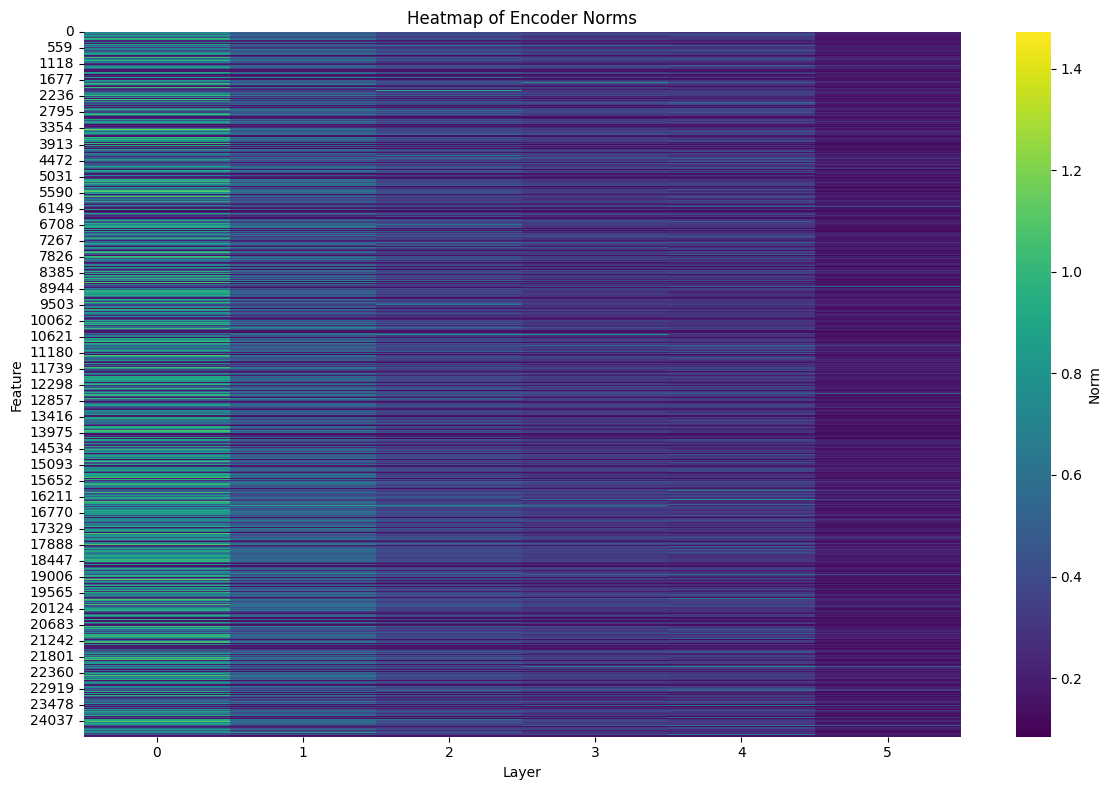

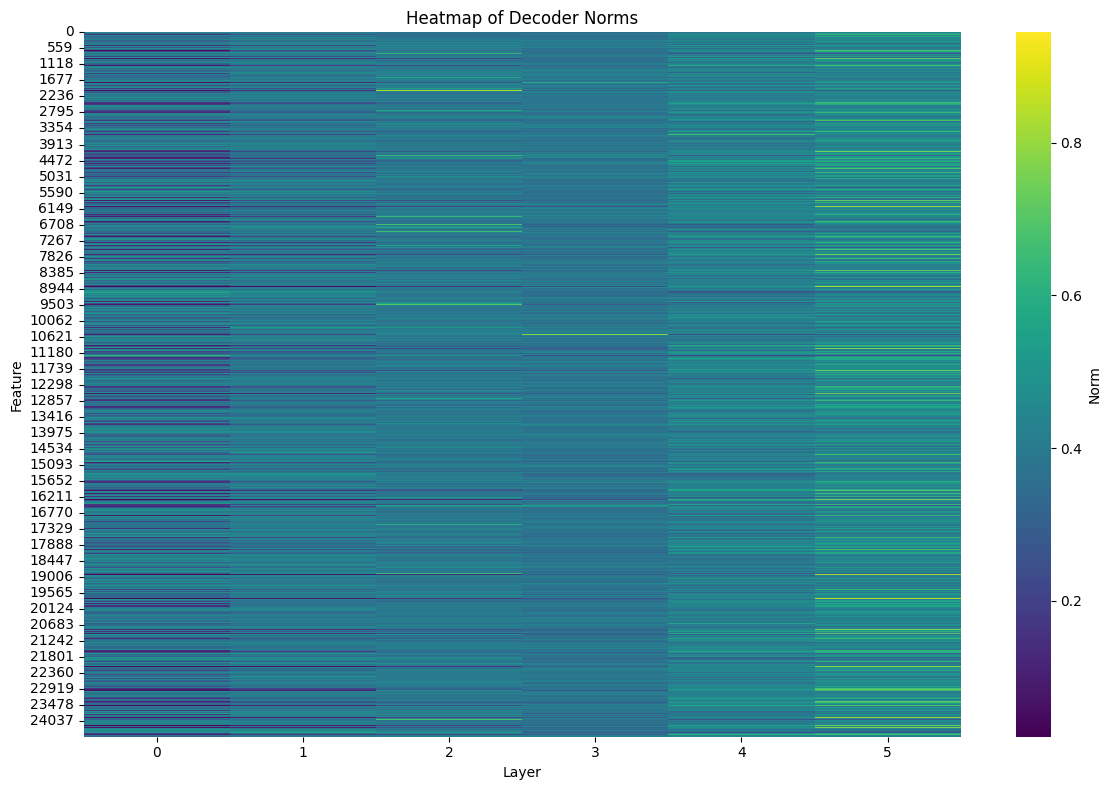

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(enc_norms.cpu().numpy(), cmap='viridis', cbar_kws={'label': 'Norm'})
plt.title('Heatmap of Encoder Norms')
plt.xlabel('Layer')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Optional: Create a similar heatmap for decoder norms
plt.figure(figsize=(12, 8))
sns.heatmap(dec_norms.cpu().numpy(), cmap='viridis', cbar_kws={'label': 'Norm'})
plt.title('Heatmap of Decoder Norms')
plt.xlabel('Layer')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [11]:
# Get the encoder norms for layer 3
layer_3_norms = enc_norms[:, 3]

# # Find the index of the feature with the largest norm in layer 3
# max_feature_index = torch.argmax(layer_3_norms)

# # Get the value of the largest norm
# max_norm_value = layer_3_norms[max_feature_index]

# print(f"Feature with the largest norm in layer 3: {max_feature_index}")
# print(f"Largest norm value in layer 3: {max_norm_value:.4f}")

# Optionally, you can get the top N features
N = 5  # Change this to get more or fewer top features
top_N_indices = torch.topk(layer_3_norms, N).indices
top_N_values = layer_3_norms[top_N_indices]

print(f"\nTop {N} features with largest norms in layer 3:")
for i, (idx, val) in enumerate(zip(top_N_indices.tolist(), top_N_values.tolist()), 1):
    print(f"{i}. Feature {idx}: {val:.4f}")



Top 5 features with largest norms in layer 3:
1. Feature 2834: 1.0186
2. Feature 21946: 0.9647
3. Feature 11152: 0.9159
4. Feature 5702: 0.8983
5. Feature 16644: 0.8862


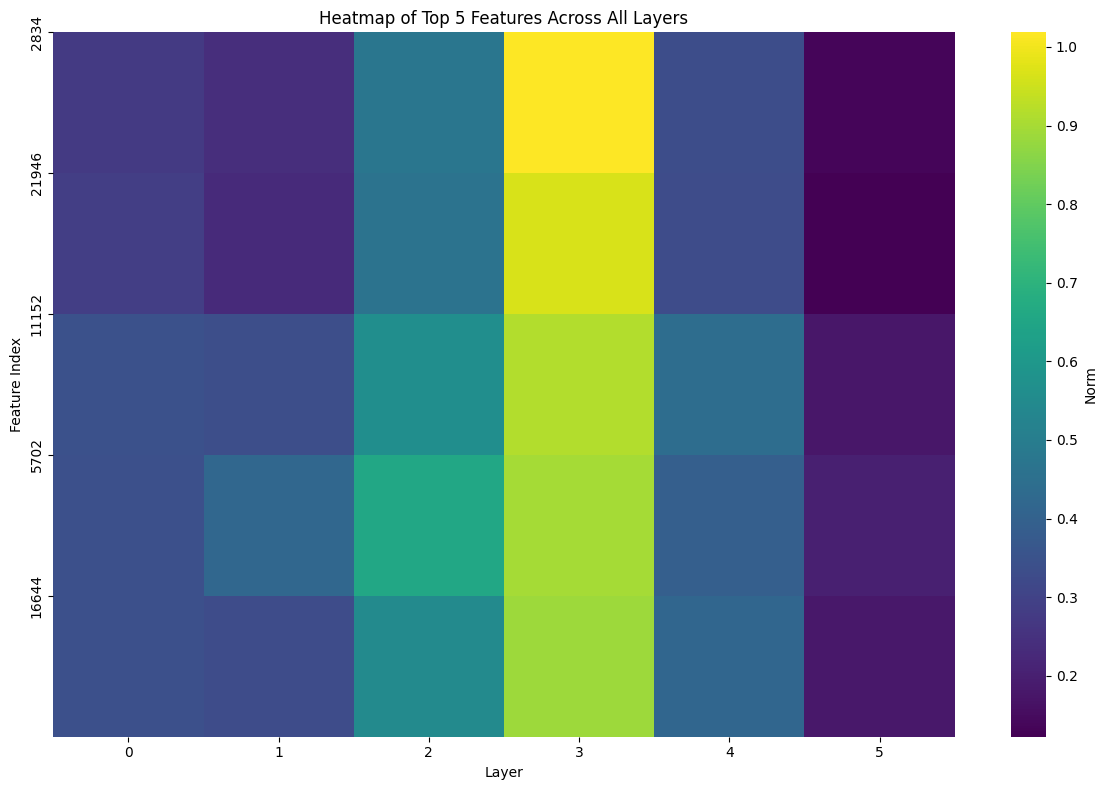

Feature indices plotted: [2834, 21946, 11152, 5702, 16644]


In [12]:

# Create a new heatmap with only the top N features
plt.figure(figsize=(12, 8))

# Extract the norms for the top N features across all layers
top_N_norms = enc_norms[top_N_indices, :]

# Create a heatmap
sns.heatmap(top_N_norms.cpu().numpy(), cmap='viridis', cbar_kws={'label': 'Norm'})

plt.title(f'Heatmap of Top {N} Features Across All Layers')
plt.xlabel('Layer')
plt.ylabel('Feature Index')

# Set y-axis tick labels to the actual feature indices
plt.yticks(range(N), top_N_indices.tolist())

plt.tight_layout()
plt.show()

# Print the feature indices for reference
print(f"Feature indices plotted: {top_N_indices.tolist()}")


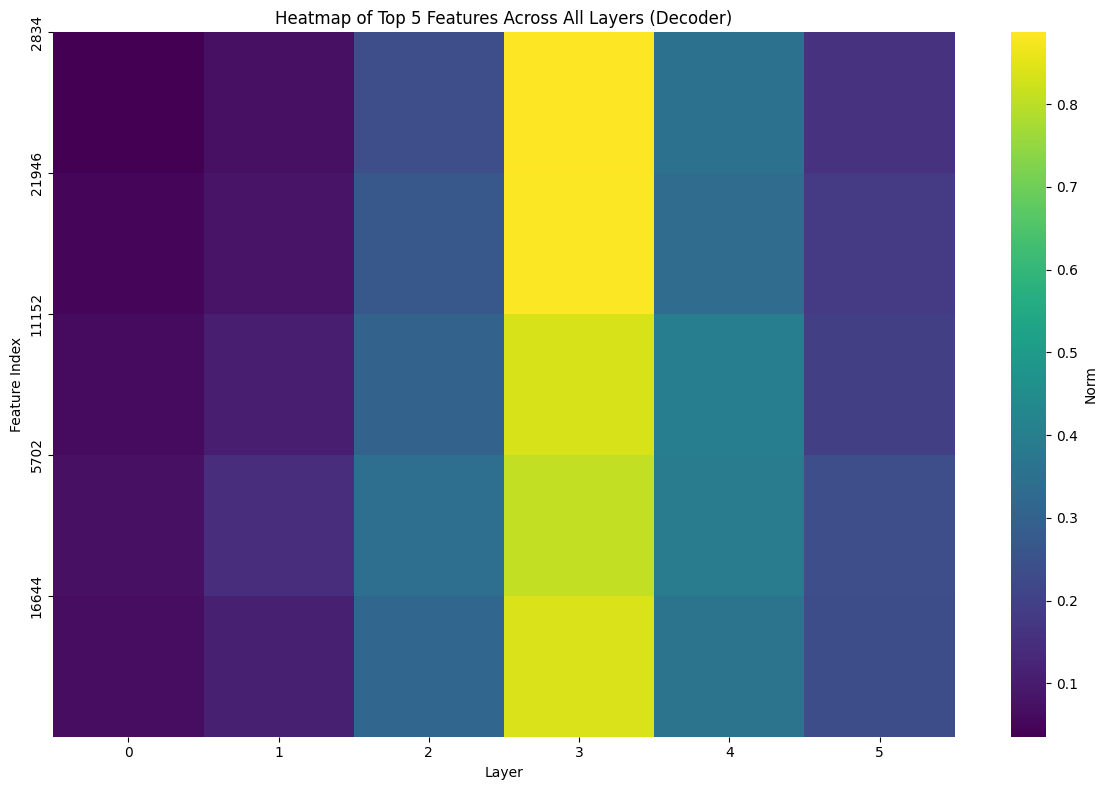

Feature indices plotted: [2834, 21946, 11152, 5702, 16644]


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [13]:
# Plot decoder norms for the top N features
plt.figure(figsize=(12, 8))

# Extract the decoder norms for the top N features across all layers
top_N_decoder_norms = dec_norms[top_N_indices, :]

# Create a heatmap for decoder norms
sns.heatmap(top_N_decoder_norms.cpu().numpy(), cmap='viridis', cbar_kws={'label': 'Norm'})

plt.title(f'Heatmap of Top {N} Features Across All Layers (Decoder)')
plt.xlabel('Layer')
plt.ylabel('Feature Index')

# Set y-axis tick labels to the actual feature indices
plt.yticks(range(N), top_N_indices.tolist())

plt.tight_layout()
plt.show()

# Print the feature indices for reference (same as before)
print(f"Feature indices plotted: {top_N_indices.tolist()}")

# Compare encoder and decoder norms
plt.figure(figsize=(12, 8))



In [14]:
seed = 42
dataset = datasets.load_dataset(
    "togethercomputer/RedPajama-Data-1T-Sample",
    split="train",
    trust_remote_code=True,
)

dataset = dataset.train_test_split(
    test_size=0.8, seed=seed
).get("test").select(range(1000))

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-14m")
tokenized = chunk_and_tokenize(dataset, tokenizer, max_seq_len=64)

In [15]:
def get_hidden_states(batch_ids):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Move the input to the same device as the model
    batch_ids = batch_ids.to(model.device)
    
    # Forward pass with output_hidden_states=True
    with torch.no_grad():
        outputs = model(batch_ids, output_hidden_states=True)
    
    # Return the hidden states
    return outputs.hidden_states



In [16]:
batch = tokenized['input_ids'][:100]
hiddens = get_hidden_states(batch)

# Stack the hidden states after the embedding layer (index 1 onwards)
stacked_hiddens = torch.cat(hiddens[1:], dim = -1)

# Print the shape of the stacked hidden states
print(f"Shape of stacked hidden states: {stacked_hiddens.shape}")

Shape of stacked hidden states: torch.Size([100, 64, 3072])


In [17]:
feature_encoder_weights.shape

torch.Size([24576, 3072])

In [18]:
# Ensure feature_encoder_weights and feature_encoder_bias are on the same device as stacked_hiddens
feature_encoder_weights = feature_encoder_weights.to(stacked_hiddens.device)
feature_encoder_bias = feature_encoder_bias.to(stacked_hiddens.device)

# Multiply feature_encoder_weights against stacked_hiddens on the embedding dimension
# feature_encoder_weights shape: [3072, 768]
# stacked_hiddens shape: [100, 64, 768]
# Desired output shape: [100, 64, 3072]
encoded_features = torch.einsum('be,nse->nsb', feature_encoder_weights, stacked_hiddens)

# Add feature_encoder_bias
encoded_features = encoded_features + feature_encoder_bias.unsqueeze(0).unsqueeze(0)
print(f"Shape of encoded features: {encoded_features.shape}")

# Select encoded features which are k largest along the final dimension
k = 128 # Number of top features to select

# Get the indices of the k largest values along the final dimension
top_k_indices = torch.topk(encoded_features, k=k, dim=-1).indices

# Determine the k'th strongest activation value for each sample and sequence position
k_th_strongest = torch.topk(encoded_features, k=k, dim=-1).values[:, :, -1].unsqueeze(-1)

# Create a binary mask for features that are at least as large as the k'th strongest
binary_mask = (encoded_features >= k_th_strongest).float()

print(f"Shape of binary mask: {binary_mask.shape}")
print(f"Number of active features: {binary_mask.sum().item()}")
print(f"Average number of active features per token: {binary_mask.sum() / (binary_mask.shape[0] * binary_mask.shape[1]):.2f}")



Shape of encoded features: torch.Size([100, 64, 24576])
Shape of binary mask: torch.Size([100, 64, 24576])
Number of active features: 819200.0
Average number of active features per token: 128.00


In [19]:
# Initialize a tensor to store the active features across the dataset
total_active_features = torch.zeros(binary_mask.shape[-1], device=binary_mask.device)

# Set batch size
batch_size = 256
exclude_first_k_tokens = 4

# Create a DataLoader for efficient batching
dataloader = torch.utils.data.DataLoader(
    tokenized, batch_size=batch_size, shuffle=False
)

# Loop through the dataset
for batch in tqdm(dataloader, desc="Processing batches"):
    # Move batch to the same device as the model
    input_ids = batch["input_ids"].to(model.device)
    attention_mask = torch.ones_like(input_ids, device=model.device)

    # Get hidden states
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
        )
        hiddens = outputs.hidden_states

    # Stack hidden states
    stacked_hiddens = torch.cat(hiddens[1:], dim=-1)[:, exclude_first_k_tokens:, :]

    # Encode features
    encoded_features = torch.einsum(
        "be,nse->nsb", feature_encoder_weights, stacked_hiddens
    )
    encoded_features = encoded_features + feature_encoder_bias.unsqueeze(0).unsqueeze(0)

    # Get k'th strongest activation
    k_th_strongest = (
        torch.topk(encoded_features, k=k, dim=-1).values[:, :, -1].unsqueeze(-1)
    )

    # Create binary mask
    batch_binary_mask = (encoded_features >= k_th_strongest).float()

    # Sum active features across the batch
    total_active_features += batch_binary_mask.sum(dim=(0, 1))

# Calculate the proportion of active features
feature_activation_rate = total_active_features / (
    len(tokenized) * 64
)  # 64 is the sequence length

print(f"Total number of active features: {total_active_features.sum().item()}")
print(
    f"Average number of active features per token: {total_active_features.sum() / (len(tokenized) * 64):.2f}"
)


Processing batches: 100%|██████████| 77/77 [00:19<00:00,  3.95it/s]

Total number of active features: 149952160.0
Average number of active features per token: 120.00


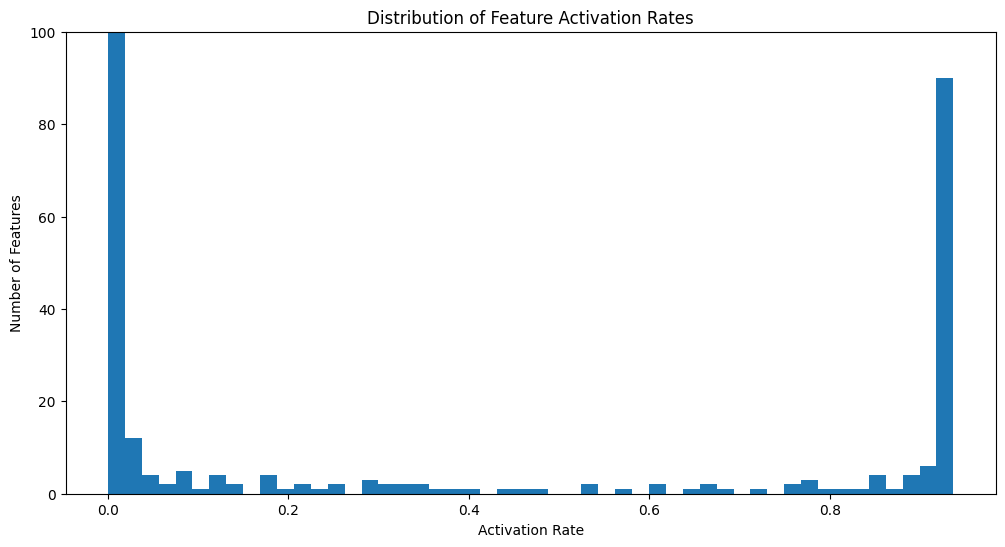

In [20]:

# Plot the distribution of feature activation rates
plt.figure(figsize=(12, 6))
plt.hist(feature_activation_rate.cpu().numpy(), bins=50)
plt.title("Distribution of Feature Activation Rates")
plt.xlabel("Activation Rate")
plt.ylim(0, 100)  # Restrict y-axis to a maximum height of 40
plt.ylabel("Number of Features")
plt.show()

In [21]:
zero_activation_features = torch.where(feature_activation_rate == 0)[0]

In [22]:
# Identify features with zero activation rate
min_feature_activation_rate = 0.01

active_features = torch.where(feature_activation_rate > min_feature_activation_rate)[0]

# Create filtered versions of encoder and decoder components
filtered_feature_encoder_weights = feature_encoder_weights[active_features]
filtered_feature_encoder_bias = feature_encoder_bias[active_features]
filtered_feature_decoder_weights = feature_decoder_weights[active_features]

# print(f"Number of features with activation : {len(active_features)}")
# print(f"Shape of filtered encoder weights: {filtered_feature_encoder_weights.shape}")
# print(f"Shape of filtered encoder bias: {filtered_feature_encoder_bias.shape}")
# print(f"Shape of filtered decoder weights: {filtered_feature_decoder_weights.shape}")
# print(f"Shape of filtered decoder bias: {filtered_feature_decoder_bias.shape}")

In [23]:
filtered_feature_encoder_weights.shape

torch.Size([219, 3072])

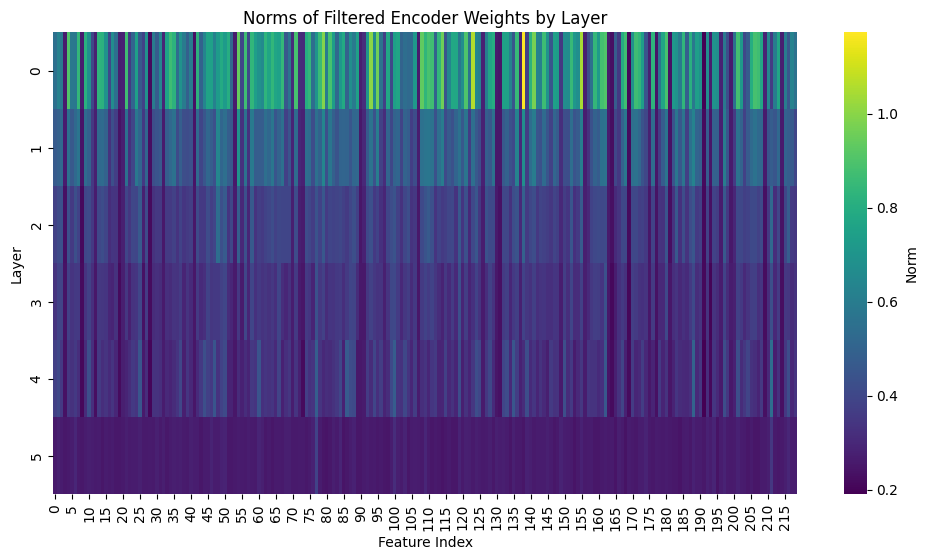

In [24]:
# Calculate the norms of the filtered encoder weights by layer
num_layers = 6  # Assuming 6 layers based on the model config
layer_size = filtered_feature_encoder_weights.shape[1] // num_layers

# Split the filtered encoder weights by layer along last dimension
layer_weights = torch.split(filtered_feature_encoder_weights, layer_size, dim=1)

# Calculate norms for each layer
layer_norms = [layer.norm(dim=1) for layer in layer_weights]

# Stack the norms into a single tensor
stacked_norms = torch.stack(layer_norms)

# Create a heatmap of how the norms vary by layer
plt.figure(figsize=(12, 6))
sns.heatmap(stacked_norms.cpu().numpy(), cmap='viridis', cbar_kws={'label': 'Norm'})
plt.title('Norms of Filtered Encoder Weights by Layer')
plt.xlabel('Feature Index')
plt.ylabel('Layer')
plt.show()



In [25]:
filtered_feature_encoder_weights.shape

torch.Size([219, 3072])

Layer 0:
  Number of features after additional filtering: 191


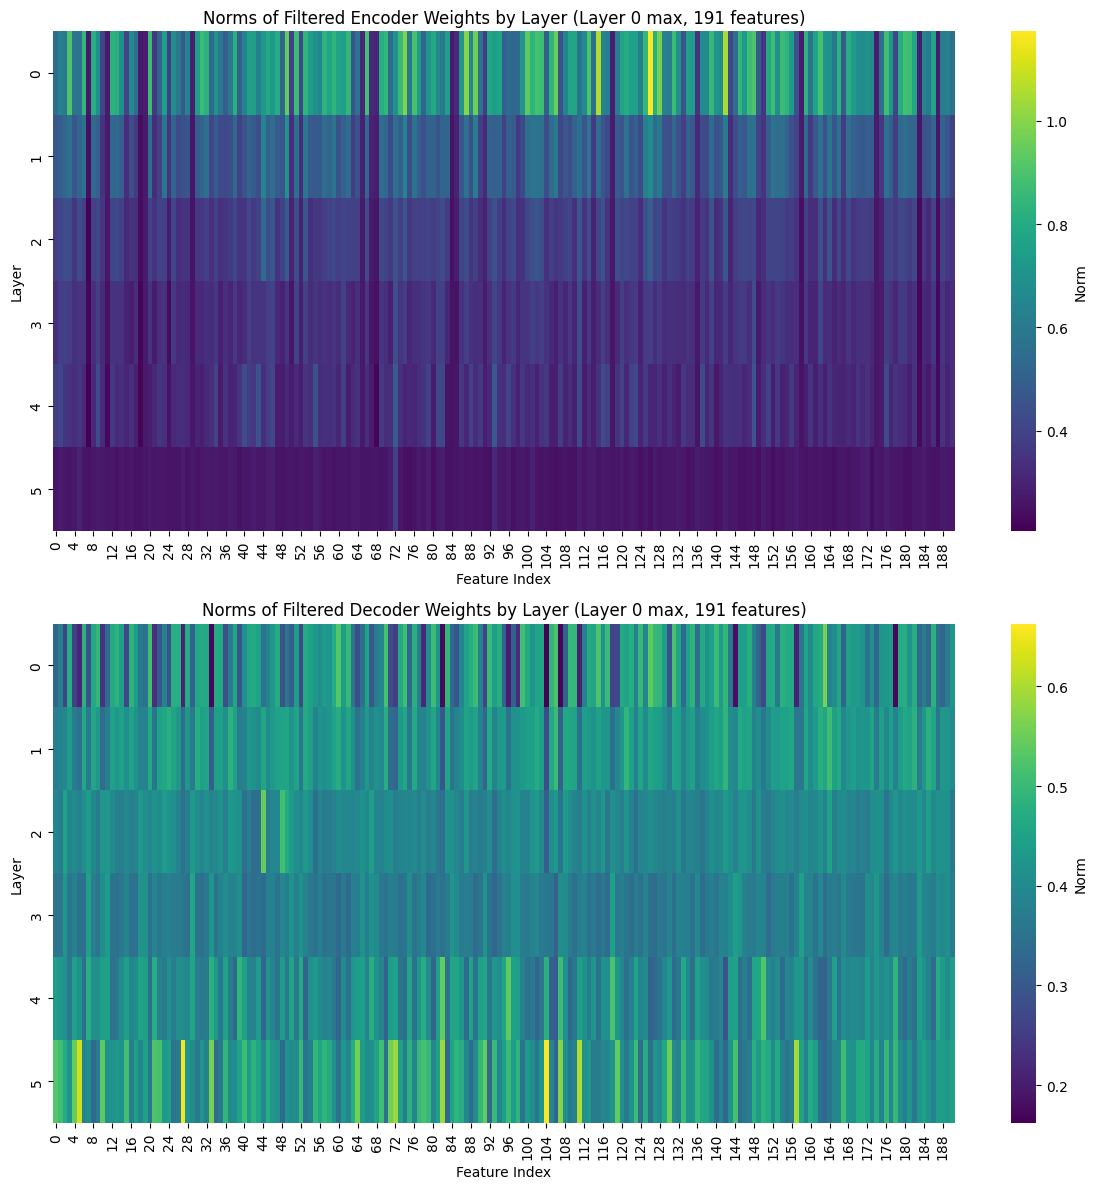

  Number of active features: 219
  Mean encoder norm: 0.3934
  Mean decoder norm: 0.4032

Layer 1:
  Number of features after additional filtering: 11


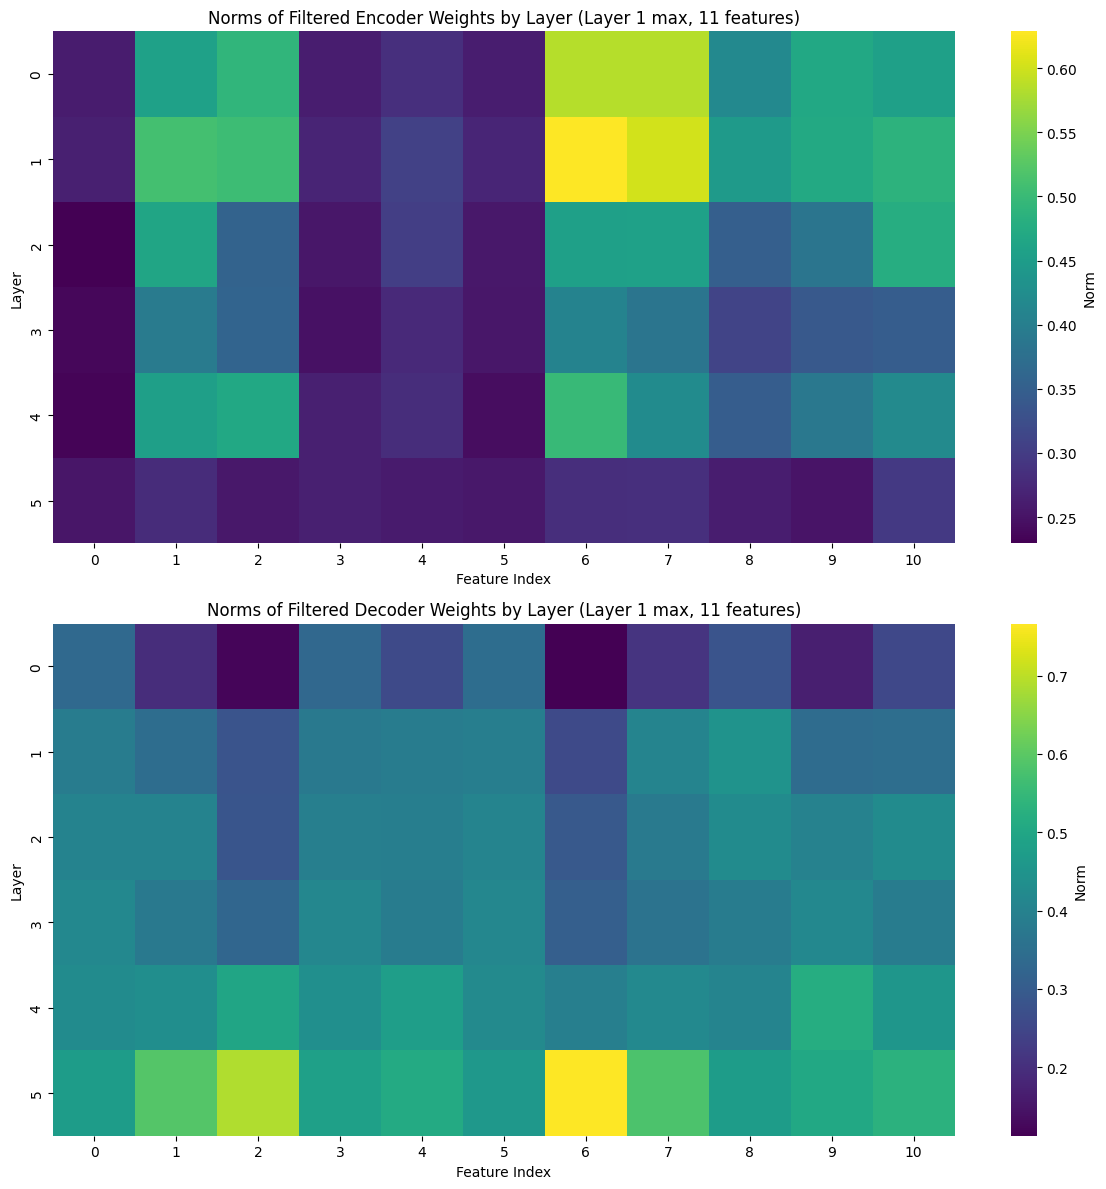

  Number of active features: 219
  Mean encoder norm: 0.3934
  Mean decoder norm: 0.4032

Layer 2:
  Number of features after additional filtering: 2


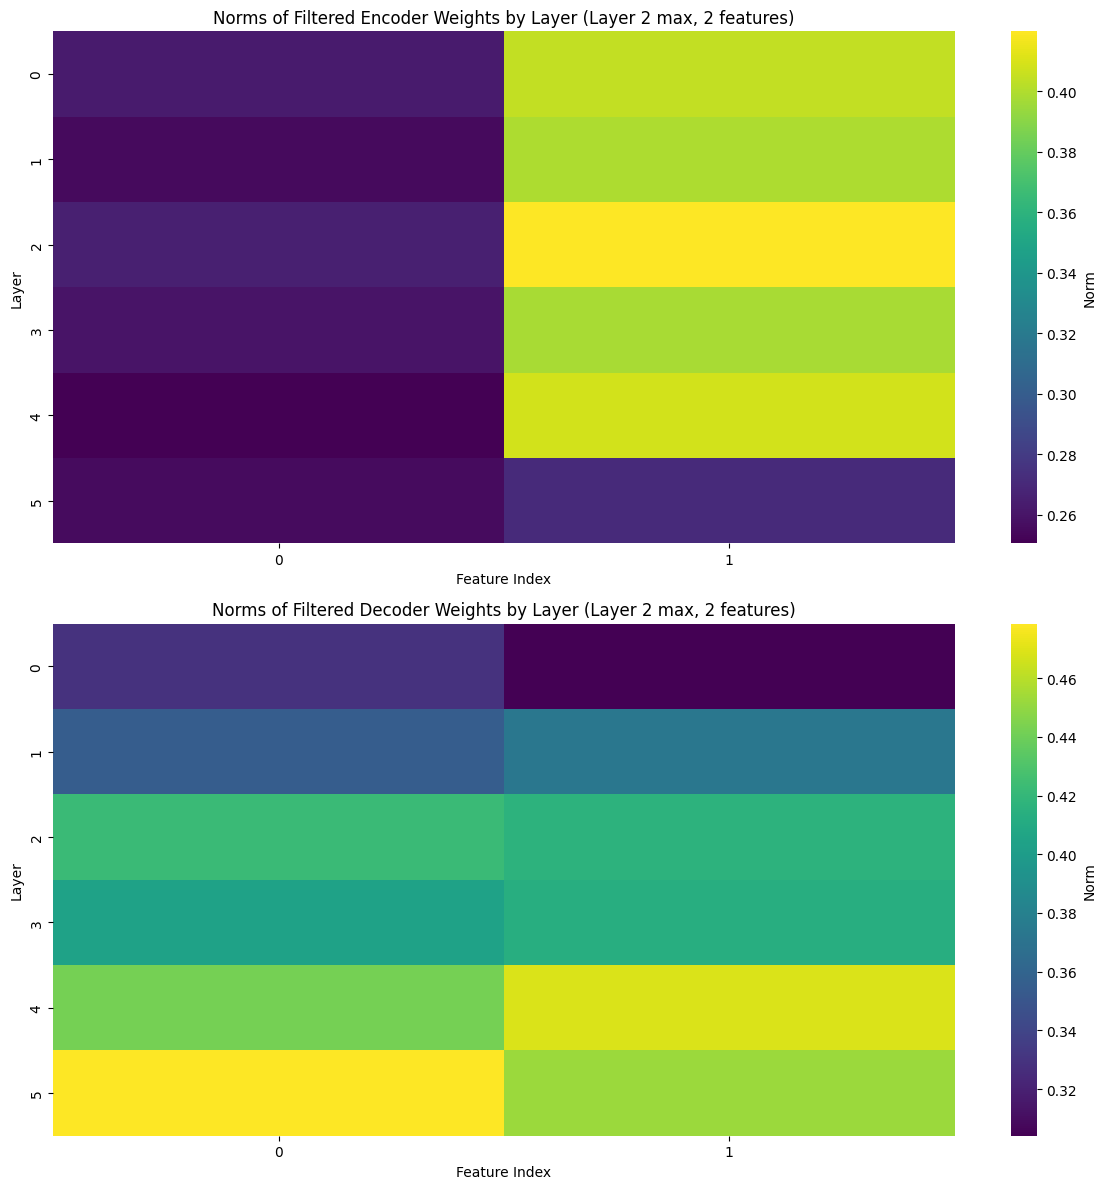

  Number of active features: 219
  Mean encoder norm: 0.3934
  Mean decoder norm: 0.4032

Layer 3:
  Number of features after additional filtering: 2


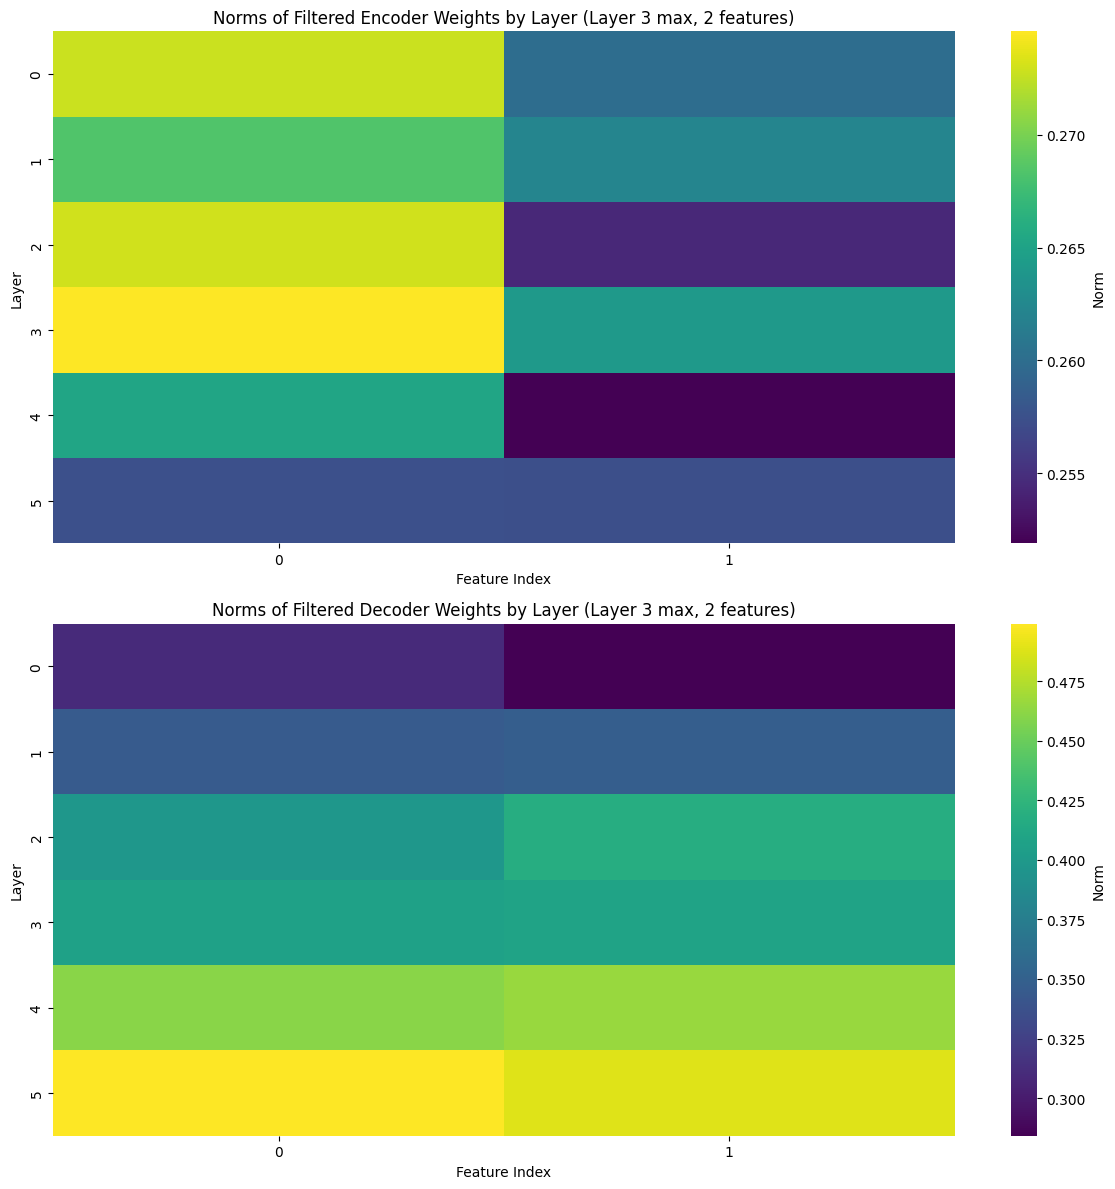

  Number of active features: 219
  Mean encoder norm: 0.3934
  Mean decoder norm: 0.4032

Layer 4:
  Number of features after additional filtering: 3


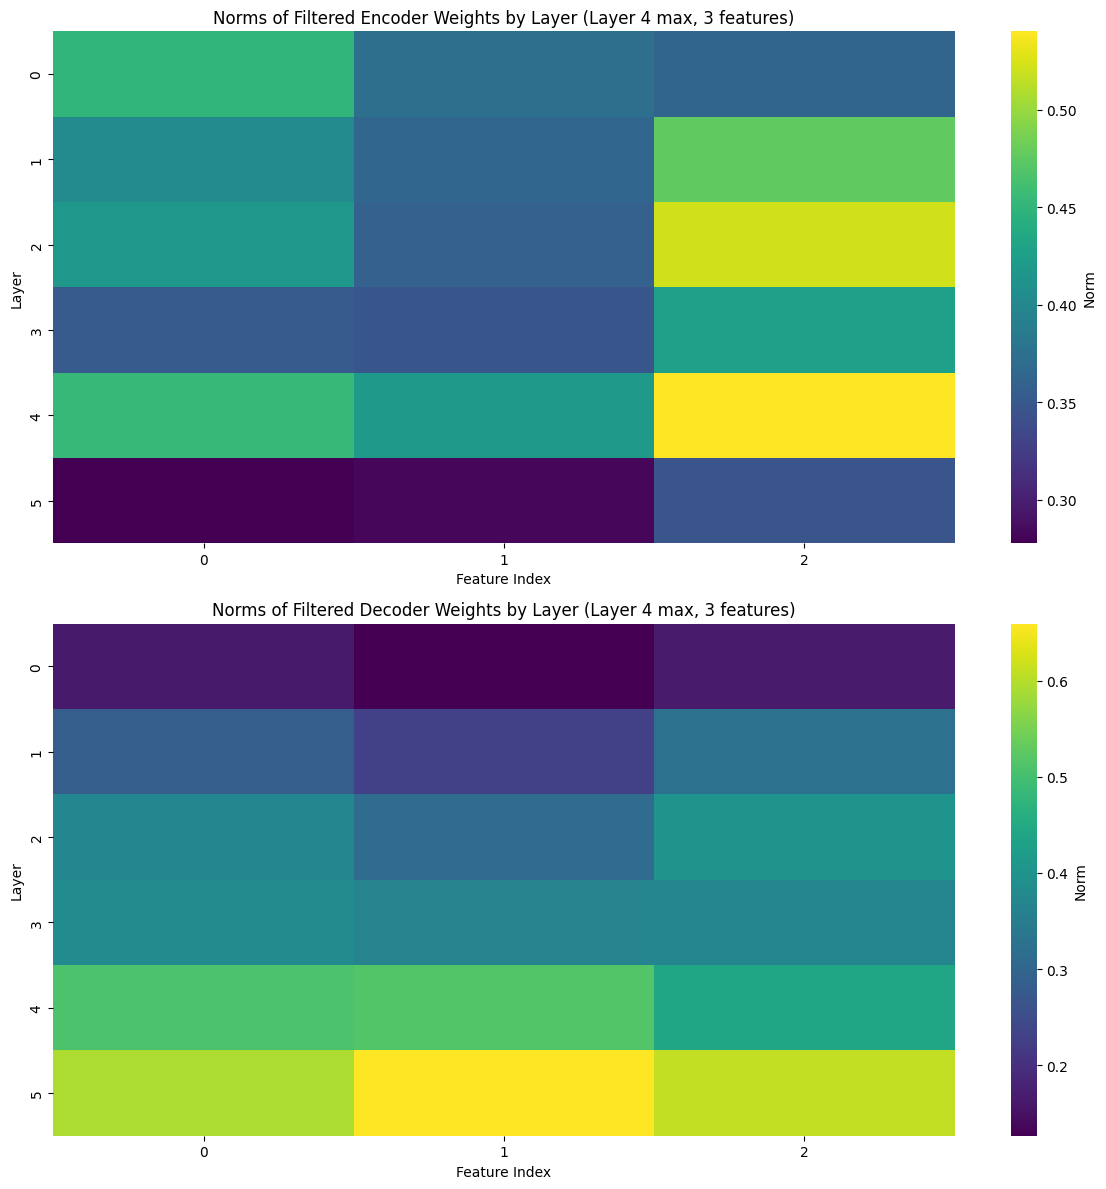

  Number of active features: 219
  Mean encoder norm: 0.3934
  Mean decoder norm: 0.4032

Layer 5:
  Number of features after additional filtering: 10


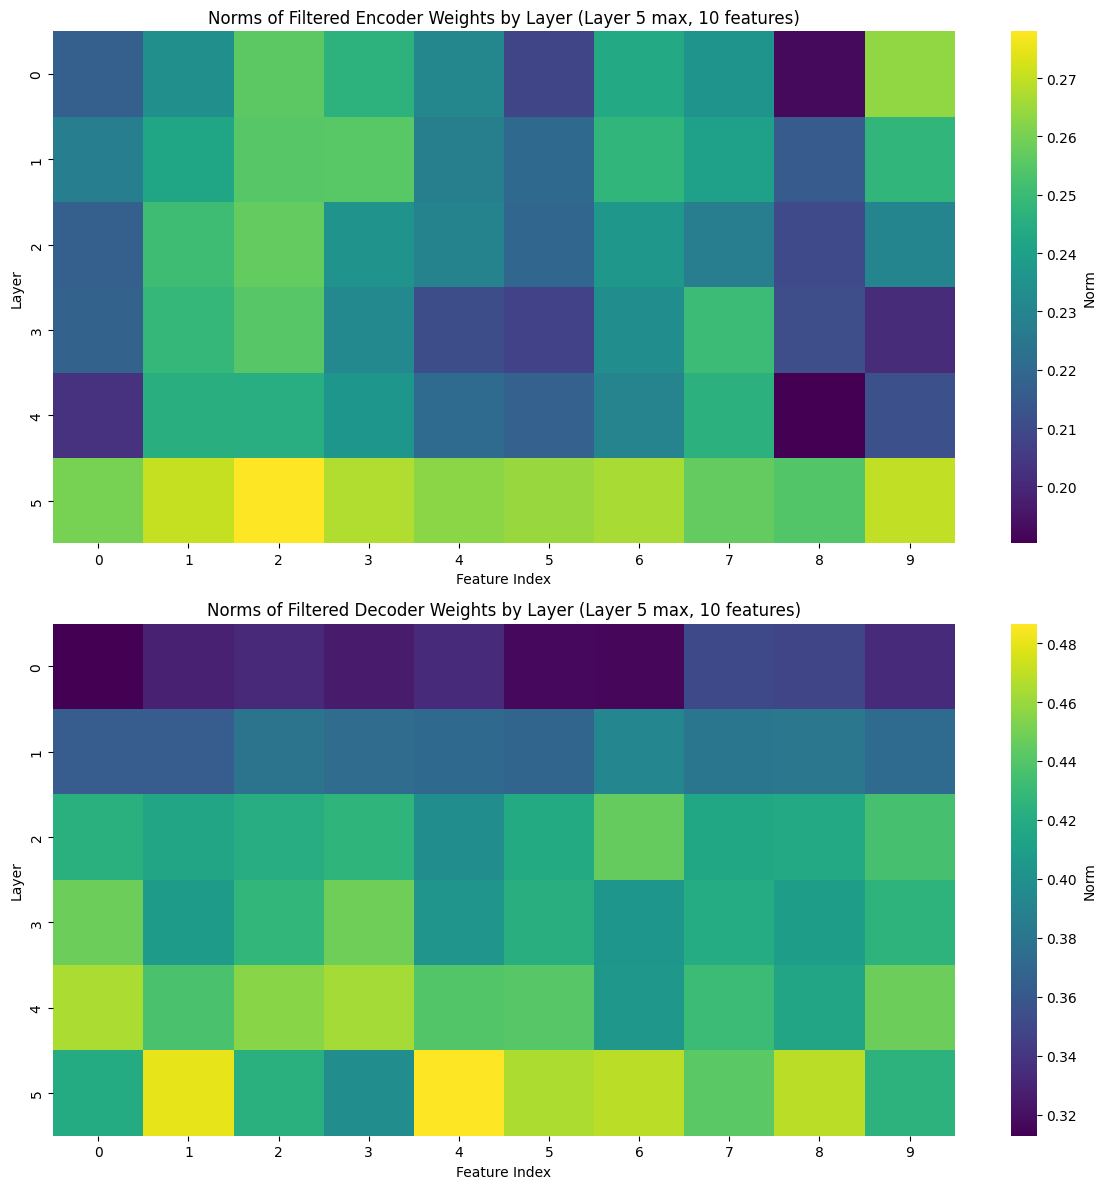

  Number of active features: 219
  Mean encoder norm: 0.3934
  Mean decoder norm: 0.4032



In [26]:
# Initialize a dictionary to store the filtering splits
max_layer_filtering_splits = []

# Flag to enable saving plots and metadata
save_flag = True  # Set this to False if you don't want to save
save_folder = f"../assets/{model_name}/layer_filtering_results_exclude_{exclude_first_k_tokens}"  # Folder to save results

if save_flag:
    import json
    import os

    os.makedirs(save_folder, exist_ok=True)
    metadata = {}

for i in range(6):  # Loop through layers 0 to 5
    # Calculate the norms for each layer
    num_layers = 6  # Assuming 6 layers based on the model config
    layer_size = filtered_feature_encoder_weights.shape[1] // num_layers

    # Split the filtered encoder and decoder weights by layer
    encoder_layer_weights = torch.split(
        filtered_feature_encoder_weights, layer_size, dim=1
    )
    decoder_layer_weights = torch.split(
        filtered_feature_decoder_weights, layer_size, dim=1
    )

    # Calculate norms for each layer
    encoder_layer_norms = [layer.norm(dim=1) for layer in encoder_layer_weights]
    decoder_layer_norms = [layer.norm(dim=1) for layer in decoder_layer_weights]

    # Stack the norms into tensors
    encoder_stacked_norms = torch.stack(encoder_layer_norms)
    decoder_stacked_norms = torch.stack(decoder_layer_norms)

    # Calculate the layer with the largest norm for each feature
    max_norm_layers = encoder_stacked_norms.argmax(dim=0)

    # Create a mask for features where layer i has the largest norm
    layer_mask = max_norm_layers == i

    # Apply the mask to filter the features
    filtered_encoder_norms = encoder_stacked_norms[:, layer_mask]
    filtered_decoder_norms = decoder_stacked_norms[:, layer_mask]

    if filtered_encoder_norms.numel() == 0 or filtered_decoder_norms.numel() == 0:
        print(f"No features left after filtering layer {i}")
        if save_flag:
            metadata[f"layer_{i}"] = {
                "num_features": 0,
                "exclude_first_k_tokens": exclude_first_k_tokens,
            }
        continue

    # Record the filtering split for this layer
    max_layer_filtering_splits.append(
        {
            "filtered_encoder": filtered_feature_encoder_weights[layer_mask, :],
            "filtered_encoder_bias": filtered_feature_encoder_bias[layer_mask],
            "filtered_decoder": filtered_feature_decoder_weights[layer_mask, :],
        }
    )

    # Print the number of features after additional filtering
    num_features = filtered_encoder_norms.shape[1]
    print(f"Layer {i}:")
    print(f"  Number of features after additional filtering: {num_features}")

    # Create heatmaps of how the norms vary by layer
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    sns.heatmap(
        filtered_encoder_norms.cpu().numpy(),
        cmap="viridis",
        cbar_kws={"label": "Norm"},
        ax=ax1,
    )
    ax1.set_title(
        f"Norms of Filtered Encoder Weights by Layer (Layer {i} max, {num_features} features)"
    )
    ax1.set_xlabel("Feature Index")
    ax1.set_ylabel("Layer")

    sns.heatmap(
        filtered_decoder_norms.cpu().numpy(),
        cmap="viridis",
        cbar_kws={"label": "Norm"},
        ax=ax2,
    )
    ax2.set_title(
        f"Norms of Filtered Decoder Weights by Layer (Layer {i} max, {num_features} features)"
    )
    ax2.set_xlabel("Feature Index")
    ax2.set_ylabel("Layer")

    plt.tight_layout()

    if save_flag:
        plt.savefig(os.path.join(save_folder, f"layer_{i}_heatmap.png"))

    plt.show()

    # Print some statistics
    print(f"  Number of active features: {encoder_stacked_norms.shape[1]}")
    print(f"  Mean encoder norm: {encoder_stacked_norms.mean().item():.4f}")
    print(f"  Mean decoder norm: {decoder_stacked_norms.mean().item():.4f}")
    print()  # Add a blank line for readability between iterations

    if save_flag:
        metadata[f"layer_{i}"] = {
            "num_features": num_features,
            "active_features": encoder_stacked_norms.shape[1],
            "mean_encoder_norm": encoder_stacked_norms.mean().item(),
            "mean_decoder_norm": decoder_stacked_norms.mean().item(),
            "exclude_first_k_tokens": exclude_first_k_tokens,
        }

if save_flag:
    with open(os.path.join(save_folder, "metadata.json"), "w") as f:
        json.dump(metadata, f, indent=2)


In [27]:
for i in range(len(max_layer_filtering_splits)):
    print(max_layer_filtering_splits[i]['filtered_encoder'].shape, max_layer_filtering_splits[i]['filtered_encoder_bias'].shape, max_layer_filtering_splits[i]['filtered_decoder'].shape)

torch.Size([191, 3072]) torch.Size([191]) torch.Size([191, 3072])
torch.Size([11, 3072]) torch.Size([11]) torch.Size([11, 3072])
torch.Size([2, 3072]) torch.Size([2]) torch.Size([2, 3072])
torch.Size([2, 3072]) torch.Size([2]) torch.Size([2, 3072])
torch.Size([3, 3072]) torch.Size([3]) torch.Size([3, 3072])
torch.Size([10, 3072]) torch.Size([10]) torch.Size([10, 3072])


In [28]:
#I suspect the most efficient way to go about thos jacobian computation is to modify the gpt2 forward pass

In [29]:
# dataset = datasets.load_dataset(
#     "togethercomputer/RedPajama-Data-1T-Sample",
#     split="train",
#     trust_remote_code=True,
# ).select(range(16))
# tokenizer = AutoTokenizer.from_pretrained("gpt2")
# tokenized = chunk_and_tokenize(dataset, tokenizer, max_seq_len=64)

In [30]:
tokenized

Dataset({
    features: ['input_ids', 'overflow_to_sample_mapping'],
    num_rows: 19525
})

In [31]:
# Collect activations from GPT2
sample = tokenized[0:2]["input_ids"]

j, k = 1, 2
lam = 1e-2

common_kwargs = {
    "model": model,
    "inputs": {
        "input_ids": sample.cuda(),
        "attention_mask": torch.ones_like(sample, device="cuda:0"),
    },
    "intervention_index": j,
    "readout_index": k,
    "feature_encoder_weights": feature_encoder_weights,
    "feature_encoder_bias": feature_encoder_bias,
    "feature_decoder_weights": feature_decoder_weights,
    "activation_rates": feature_activation_rate,
    "feature_select_k": 1,
    "feature_select_percentile": None,
    "num_tokens": 1,
    "exclude_first_k_tokens": 0,
}

(
    activation_positions,
    consequent_embeddings_intervened,
    causal_embeddings,
    v_j,
    v_k,
    _,
    is_valid
) = process_text(
    **common_kwargs,
    lambda_value=lam,
)

(_, consequent_embeddings_clean, _, _, _, _, _) = process_text(
    **common_kwargs,
    lambda_value=0,
)

In [32]:
from torch.func import functional_call, jacrev, vmap


def compute_jacobian(model, j_activations, pos, j, k):
    """
    Compute the batched Jacobians of layer k's activations with respect to layer j's activations for some select K tokens.

    Args:
    - model: GPT2Model instance
    - j_activations: activations of layer j (shape: [batch_size, seq_len, hidden_size])
    - pos: token positions of shape (B, K)
    - j: index of the input layer
    - k: index of the output layer

    Returns:
    - Batch of Jacobians
    """
    # Ensure j_activations requires grad
    j_activations.requires_grad_(True)

    # Forward pass to get k_activations
    def forward_to_k(x):
        # Forward pass from j to k
        activations = x.unsqueeze(1)
        for layer_idx in range(j, k + 1):

            def functional_layer(inputs):
                if "gpt" in model_name:
                    layer, params = (
                        model.transformer.h[layer_idx],
                        dict(model.transformer.h[layer_idx].named_parameters()),
                    )
                else:
                    layer, params = (
                        model.gpt_neox.layers[layer_idx],
                        dict(model.gpt_neox.layers[layer_idx].named_parameters()),
                    )

                return functional_call(
                    layer,
                    params,
                    inputs,
                )[0]

            activations = functional_layer(activations)

        return activations

    # good idea to sum here to reduce bias?
    j_activations = j_activations.gather(
        1, pos.unsqueeze(-1).expand(-1, -1, j_activations.shape[-1])
    ).sum(dim=1, keepdim=True)

    # Compute Jacobian
    jacobian = vmap(jacrev(forward_to_k))(j_activations)

    return jacobian.squeeze()
    # But if we're pre-computing, we could just return the jacobian.squeeze(0,2)

In [33]:
# Generate random input
# batch_size, seq_len = 1, 10
# j_activations = torch.randn(batch_size, seq_len, 768, device="cuda:1")
i = torch.zeros(causal_embeddings.shape[0], 1, device="cuda").long()

print(i.shape, causal_embeddings.shape)

jacobian = compute_jacobian(model, causal_embeddings, i, j, k)

print(f"Jacobian shape: {jacobian.shape}")

torch.Size([2, 1]) torch.Size([2, 64, 512])
Jacobian shape: torch.Size([2, 512, 512])


/home/sid/miniconda3/envs/sae/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [34]:
v_j.shape

torch.Size([2, 1, 512])

In [35]:
# Check consequent_embeddings ~= original_embeddings_at_the_higher_layer + jacobian @ v_j * lam
with torch.no_grad():
    jacobian_approx = (
        consequent_embeddings_clean
        + torch.bmm(
            v_j.gather(1, i.unsqueeze(-1).expand(-1, -1, v_j.shape[-1])),
            jacobian.transpose(-2, -1),
        )
        * lam
    )

error = torch.mean((consequent_embeddings_intervened - jacobian_approx) ** 2)

print(f"error: {error}")

error: 1.136332684836816e-06


In [36]:
v_j.shape

torch.Size([2, 1, 512])

In [37]:
def get_active_latents_first_pos(
    output, feature_encoder_weights, feature_encoder_bias, i, j
):
    # concat hidden states for layer range
    all_hidden_states = torch.cat(
        [output.hidden_states[idx] for idx in range(i, j + 1)], dim=-1
    )
    feature_activation = (
        einsum(all_hidden_states, feature_encoder_weights.T, "b s e, e n -> b s n")
        - feature_encoder_bias
    )
    max_feature_activation, _ = torch.max(feature_activation, dim=-1)
    # get first positions where maximal feature is activated
    first_activation_positions = (
        (max_feature_activation > 0).float().argmax(dim=1, keepdim=True)
    )
    expanded_pos = first_activation_positions.unsqueeze(-1).expand(
        -1, -1, all_hidden_states.shape[-1]
    )
    token_activations = all_hidden_states.gather(1, expanded_pos)
    num_fired = (token_activations > 0).sum(dim=-1)

    return num_fired

In [38]:
dataset = datasets.load_dataset(
    "togethercomputer/RedPajama-Data-1T-Sample",
    split="train",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [39]:
# # tokenized = chunk_and_tokenize(dataset, tokenizer, max_seq_len=128, num_proc = 4, batch_size = 100)
# import pickle
# tokenized_path = 'tokenized_dataset.pkl'
# with open(tokenized_path, 'wb') as f:
#     pickle.dump(tokenized, f)
# print("Tokenized dataset and saved to file.")

In [40]:
import os
import pickle

# Define the path for saving/loading the tokenized dataset
tokenized_path = "tokenized_dataset.pkl"

# Check if the tokenized dataset already exists
if os.path.exists(tokenized_path):
    # Load the tokenized dataset
    with open(tokenized_path, "rb") as f:
        tokenized = pickle.load(f)
    print("Loaded tokenized dataset from file.")
else:
    # If not present, tokenize the dataset
    tokenized = chunk_and_tokenize(
        dataset, tokenizer, max_seq_len=128, num_proc=os.cpu_count(), batched=True
    )

    # Save the tokenized dataset
    with open(tokenized_path, "wb") as f:
        pickle.dump(tokenized, f)
    print("Tokenized dataset and saved to file.")


Loaded tokenized dataset from file.


In [41]:
# Define, lower and upper bounds for layers
i, j = 0, 5

In [42]:
# import gc

import matplotlib.pyplot as plt

num_samples = 8192
bsz = 128
# for each sample compute activation positions and fired pre-act latents
sample = tokenized.select(range(num_samples))

# dist = []

# for batch in tqdm(sample.iter(bsz), total=num_samples // bsz):
#     with torch.no_grad():
#         out = model(
#             input_ids=batch["input_ids"].cuda().unsqueeze(0), output_hidden_states=True
#         )
#     num_active = get_active_latents_first_pos(
#         out, feature_encoder_weights, feature_encoder_bias, i, j
#     )
#     dist.extend(num_active.squeeze().cpu().tolist())

# torch.cuda.empty_cache()
# gc.collect()


# # Create the histogram
# plt.figure(figsize=(10, 6))
# plt.title("Active Latents on Tokens activating Max Feature")
# _ = plt.hist(dist, bins=30, edgecolor="black")

In [43]:
#Goal: modify the code below, so that instead of taking the most active latent

In [44]:
def get_active_latents_heatmap(
    output, feature_encoder_weights, feature_encoder_bias, i, j
):
    # Concatenate hidden states for layer range
    all_hidden_states = torch.cat(
        [output.hidden_states[idx] for idx in range(i, j + 1)], dim=-1
    )

    # Calculate feature activation
    feature_activation = (
        torch.einsum("bse,en->bsn", all_hidden_states, feature_encoder_weights.T)
        - feature_encoder_bias
    )

    # Count number of active latents for each token
    num_active_latents = (feature_activation > 0).sum(dim=-1)

    return num_active_latents


def visualize_heatmap_batch(heatmap_data, token_labels_batch, max_tokens_display=30):
    batch_size, seq_length = heatmap_data.shape

    # Create a figure with subplots for each batch item
    fig, axes = plt.subplots(batch_size, 1, figsize=(20, 3 * batch_size), squeeze=False)
    fig.suptitle("Active Latents Heatmap (Batch)", fontsize=16)

    for b in range(batch_size):
        ax = axes[b, 0]

        # Limit the number of tokens displayed
        display_tokens = min(seq_length, max_tokens_display)
        heatmap = heatmap_data[b, :display_tokens].unsqueeze(0).cpu().numpy()
        token_labels = token_labels_batch[b][:display_tokens]

        sns.heatmap(
            heatmap,
            cmap="YlOrRd",
            xticklabels=token_labels,
            yticklabels=[""],
            ax=ax,
            cbar=(b == batch_size - 1),
        )  # Only show colorbar for the last subplot

        ax.set_title(f"Batch item {b}")
        ax.set_xlabel("Tokens")

        # Rotate and align x-axis labels for better readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

        # Add ellipsis if not all tokens are displayed
        if display_tokens < seq_length:
            ax.text(
                display_tokens + 0.5,
                0.5,
                "...",
                verticalalignment="center",
                horizontalalignment="left",
            )

    plt.tight_layout()
    plt.show()

In [45]:
def active_latents_heatmap(i, j):
    sample_input = tokenized.select(range(4))
    out = model(input_ids=sample_input["input_ids"].cuda(), output_hidden_states=True)

    active_latents_tokenwise = get_active_latents_heatmap(
        out, feature_encoder_weights, feature_encoder_bias, i, j
    )
    visualize_heatmap_batch(
        active_latents_tokenwise,
        [tokenizer.convert_ids_to_tokens(x) for x in sample_input["input_ids"]],
        j,
    )

In [46]:
@torch.no_grad()
def compute_causal_attribution_strength(
    j,
    k,
    model,
    inputs,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    lambda_value: float = 1.0,
    feature_select_k: int = 1,
    feature_select_percentile: float = None,
    top_k_tokens: int = 1,
    exclude_first_k_tokens: int = 0,
    feature_indices=None,
):
    all_metrics = []
    all_is_valid = []

    for top_kth_token in range(1, top_k_tokens + 1):
        (
            first_activation_positions,
            consequent_embeddings_intervened,
            causal_embeddings,
            v_j,
            v_k,
            max_feature_index,
            is_valid,
        ) = process_text(
            model=model,
            inputs=inputs,
            intervention_index=j,
            readout_index=k,
            lambda_value=lambda_value,
            feature_encoder_weights=feature_encoder_weights,
            feature_encoder_bias=feature_encoder_bias,
            feature_decoder_weights=feature_decoder_weights,
            feature_select_k=feature_select_k,
            feature_select_percentile=feature_select_percentile,
            num_tokens=top_kth_token,
            exclude_first_k_tokens=exclude_first_k_tokens,
            feature_indices=feature_indices,
        )

        expanded_pos = first_activation_positions.unsqueeze(-1).expand(
            -1, -1, causal_embeddings.shape[-1]
        )
        v_j = v_j.gather(2, expanded_pos)
        v_k = v_k.gather(2, expanded_pos)

        # If all batch elements are invalid, return zeros
        if not is_valid.any():
            all_metrics.append(
                tuple(torch.zeros(1) for _ in range(9))
            )  # Added one more zero tensor for is_valid
            continue

        jacobian = compute_jacobian(
            model, causal_embeddings, first_activation_positions, j, k
        )

        v_k_norm_squared = torch.norm(v_k, p=2, dim=(1, 2)).pow(2)  # shape: (valid_B,)

        proportion_explained = (
            torch.einsum("bie,be,bi->b", jacobian, v_j.squeeze(1), v_k.squeeze(1))
            / v_k_norm_squared
        )

        pred = torch.einsum("bie,be->bi", jacobian, v_j.squeeze(1))
        causal_cosine = F.cosine_similarity(pred, v_k.squeeze(1), dim=-1)

        # if (causal_cosine < -0.9).any():
        #     print("FOUND NEGATIVE COSINE SIMILARITY at feature:", feature_indices)

        error = torch.mean((pred - v_k.squeeze(1)) ** 2, dim=-1)

        relative_error = error / v_k_norm_squared

        all_metrics.append(
            (
                proportion_explained,
                causal_cosine,
                error,
                relative_error,
                jacobian,
                v_j,
                v_k,
                max_feature_index,
            )
        )
        all_is_valid.append(is_valid)

    # Concatenate the results for all top-k tokens
    proportion_explained = torch.cat([m[0] for m in all_metrics], dim=0)
    causal_cosine = torch.cat([m[1] for m in all_metrics], dim=0)
    error = torch.cat([m[2] for m in all_metrics], dim=0)
    relative_error = torch.cat([m[3] for m in all_metrics], dim=0)
    jacobian = torch.cat([m[4] for m in all_metrics], dim=0)
    v_j = torch.cat([m[5] for m in all_metrics], dim=0)
    v_k = torch.cat([m[6] for m in all_metrics], dim=0)
    max_feature_index = [m[7] for m in all_metrics]
    is_valid = torch.cat(all_is_valid, dim=0)

    results = (
        proportion_explained,
        causal_cosine,
        error,
        relative_error,
        jacobian,
        v_j,
        v_k,
        max_feature_index,
        is_valid,
    )

    return results


In [47]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader


def plot_histograms(data, params):
    num_plots = len(data)
    num_cols = 2
    num_rows = (num_plots + 1) // 2
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10 * num_rows))
    fig.suptitle("Distribution of Metrics", fontsize=16)

    metrics = list(data.keys())
    titles = [
        "Causality Distribution",
        "Causal Cosine Distribution",
        "Error Distribution",
        "Relative Error Distribution",
    ]
    xlabels = ["Causality", "Causal Cosine", "Error", "Relative Error"]

    for idx, (metric, title, xlabel) in enumerate(zip(metrics, titles, xlabels)):
        ax = axs[idx // num_cols, idx % num_cols] if num_rows > 1 else axs[idx]
        for param, values in data[metric].items():
            ax.hist(values, bins=50, alpha=0.5, label=f"{param}")
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Frequency")
        ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        ax.grid(True)
        if metric == "causality":
            ax.set_xlim(0, 2)

    plt.tight_layout()
    plt.show()


def process_dataset(
    model,
    dataset,
    batch_size,
    i,
    j,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    lambda_value,
    feature_select_k,
    feature_select_percentile,
    num_tokens,
    exclude_first_k_tokens,
):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_causality = []
    all_causal_cosines = []
    all_errors = []
    relative_errors = []

    for batch in tqdm(dataloader):
        inputs = {"input_ids": batch["input_ids"].cuda()}
        causality, causal_cosine, error, relative_error, _, _, _, _, is_valid = (
            compute_causal_attribution_strength(
                j=i,
                k=j,
                model=model,
                inputs=inputs,
                feature_encoder_weights=feature_encoder_weights,
                feature_encoder_bias=feature_encoder_bias,
                feature_decoder_weights=feature_decoder_weights,
                lambda_value=lambda_value,
                feature_select_k=feature_select_k,
                feature_select_percentile=feature_select_percentile,
                top_k_tokens=num_tokens,
                exclude_first_k_tokens=exclude_first_k_tokens,
            )
        )

        # Only add valid items to the metric lists
        all_causality.extend(causality[is_valid].cpu().numpy())
        all_causal_cosines.extend(causal_cosine[is_valid].cpu().numpy())
        all_errors.extend(error[is_valid].cpu().numpy())
        relative_errors.extend(relative_error[is_valid].cpu().numpy())

    return (
        np.array(all_causality),
        np.array(all_causal_cosines),
        np.array(all_errors),
        np.array(relative_errors),
    )


def run_evaluation(
    params,
    model,
    dataset,
    batch_size,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    exclude_first_k_tokens,
):
    results = {
        "causality": {},
        "causal_cosines": {},
        "errors": {},
        "relative_errors": {},
    }

    for i in params["i"]:
        for j in params["j"]:
            if i >= j:
                continue  # Skip invalid layer combinations
            for lambda_value in params["lambda_value"]:
                for feature_select_k in params["feature_select_k"]:
                    for num_tokens in params["num_tokens"]:
                        for percentile in params["feature_select_percentile"]:
                            key = f"i={i}, j={j}, λ={lambda_value}, k={feature_select_k}, tokens={num_tokens}, percentile={percentile}"
                            causality, causal_cosines, errors, relative_errors = (
                                process_dataset(
                                    model=model,
                                    dataset=dataset,
                                    batch_size=batch_size,
                                    i=i,
                                    j=j,
                                    feature_encoder_weights=feature_encoder_weights,
                                    feature_encoder_bias=feature_encoder_bias,
                                    feature_decoder_weights=feature_decoder_weights,
                                    lambda_value=lambda_value,
                                    feature_select_k=feature_select_k,
                                    feature_select_percentile=percentile,
                                    num_tokens=num_tokens,
                                    exclude_first_k_tokens=exclude_first_k_tokens,
                                )
                            )
                            results["causality"][key] = causality
                            results["causal_cosines"][key] = causal_cosines
                            results["errors"][key] = errors
                            results["relative_errors"][key] = relative_errors

    plot_histograms(results, params)

    return results

In [48]:
import gc
import torch
from datasets import Dataset

# Example usage:
params = {
    "i": [0, 1, 2],  # Layer indices for intervention
    "j": [1, 2, 3],  # Layer indices for readout
    "lambda_value": [1.0],
    "feature_select_k": [1],
    "num_tokens": [1],
    "feature_select_percentile": [None],
}

# Clear GPU memory and garbage collect
torch.cuda.empty_cache()
gc.collect()

# Assuming 'tokenized' is your dataset and other variables are defined
sample_size = 1000
batch_size = 128
exclude_first_k_tokens = 0

# Select a subset of the dataset
sample_dataset = Dataset.from_dict(tokenized.select(range(sample_size)))

# Run the evaluation
results = run_evaluation(
    params=params,
    model=model,
    dataset=sample_dataset,
    batch_size=batch_size,
    feature_encoder_weights=feature_encoder_weights,
    feature_encoder_bias=feature_encoder_bias,
    feature_decoder_weights=feature_decoder_weights,
    exclude_first_k_tokens=exclude_first_k_tokens,
)

# Optional: Save results
import pickle

with open('evaluation_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Evaluation completed and results saved.")

# Optional: Analyze results
for metric, data in results.items():
    print(f"\nAnalysis for {metric}:")
    for key, values in data.items():
        print(f"  {key}:")
        print(f"    Mean: {np.mean(values):.4f}")
        print(f"    Std: {np.std(values):.4f}")
        print(f"    Min: {np.min(values):.4f}")
        print(f"    Max: {np.max(values):.4f}")

21409

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


def run_layer_pair_evaluation(
    model,
    dataset,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    num_layers,
    batch_size=128,
    lambda_value=1.0,
    feature_select_k=1,
    num_tokens=1,
    exclude_first_k_tokens=0,
):
    causal_cosines_matrix = np.zeros((num_layers, num_layers))
    causality_matrix = np.zeros((num_layers, num_layers))
    errors_matrix = np.zeros((num_layers, num_layers))
    causal_cosines_std_matrix = np.zeros((num_layers, num_layers))
    causality_std_matrix = np.zeros((num_layers, num_layers))
    errors_std_matrix = np.zeros((num_layers, num_layers))

    for i in tqdm(range(num_layers)):
        for j in range(i + 1, num_layers):  # Exclude diagonal and lower triangle
            causality, causal_cosines, errors, _, _, _, _, _, is_valid = (
                compute_causal_attribution_strength(
                    j=i,
                    k=j,
                    model=model,
                    inputs={"input_ids": dataset["input_ids"].cuda()},
                    feature_encoder_weights=feature_encoder_weights,
                    feature_encoder_bias=feature_encoder_bias,
                    feature_decoder_weights=feature_decoder_weights,
                    lambda_value=lambda_value,
                    feature_select_k=feature_select_k,
                    feature_select_percentile=None,
                    top_k_tokens=num_tokens,
                    exclude_first_k_tokens=exclude_first_k_tokens,
                )
            )

            # Filter out invalid items
            valid_causality = causality[is_valid]
            valid_causal_cosines = causal_cosines[is_valid]
            valid_errors = errors[is_valid]

            if len(valid_causality) > 0:
                causal_cosines_matrix[i, j] = valid_causal_cosines.mean().item()
                causality_matrix[i, j] = valid_causality.mean().item()
                errors_matrix[i, j] = valid_errors.mean().item()
                causal_cosines_std_matrix[i, j] = valid_causal_cosines.std().item()
                causality_std_matrix[i, j] = valid_causality.std().item()
                errors_std_matrix[i, j] = valid_errors.std().item()
            else:
                # If all items are invalid, set to NaN or some default value
                causal_cosines_matrix[i, j] = np.nan
                causality_matrix[i, j] = np.nan
                errors_matrix[i, j] = np.nan
                causal_cosines_std_matrix[i, j] = np.nan
                causality_std_matrix[i, j] = np.nan
                errors_std_matrix[i, j] = np.nan

    return (
        causal_cosines_matrix,
        causality_matrix,
        errors_matrix,
        causal_cosines_std_matrix,
        causality_std_matrix,
        errors_std_matrix,
    )


def plot_layer_heatmaps(
    causal_cosines_matrix,
    causality_matrix,
    errors_matrix,
    causal_cosines_std_matrix,
    causality_std_matrix,
    errors_std_matrix,
):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    matrices = [causal_cosines_matrix, causality_matrix, errors_matrix]
    std_matrices = [causal_cosines_std_matrix, causality_std_matrix, errors_std_matrix]
    titles = ["Causal Cosines", "Causality Scores", "Errors"]

    for ax, matrix, std_matrix, title in zip(axes, matrices, std_matrices, titles):
        sns.heatmap(matrix, ax=ax, cmap="viridis", cbar=True)
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                if matrix[i, j] != 0:
                    text = f"{matrix[i, j]:.2f}\n±{std_matrix[i, j]:.2f}"
                    ax.text(j + 0.5, i + 0.5, text, ha="center", va="center")
        ax.set_title(f"{title} Heatmap")
        ax.set_xlabel("Layer j")
        ax.set_ylabel("Layer i")

    plt.tight_layout()
    plt.show()


# Run the evaluation
num_layers = 6  # Adjust this based on your model's architecture
dataset_sample = tokenized.select(range(1000))  # Adjust sample size as needed

(
    causal_cosines_matrix,
    causality_matrix,
    errors_matrix,
    causal_cosines_std_matrix,
    causality_std_matrix,
    errors_std_matrix,
) = run_layer_pair_evaluation(
    model=model,
    dataset=dataset_sample,
    feature_encoder_weights=feature_encoder_weights,
    feature_encoder_bias=feature_encoder_bias,
    feature_decoder_weights=feature_decoder_weights,
    num_layers=num_layers,
    batch_size=128,
    lambda_value=1.0,
    feature_select_k=1,
    num_tokens=1,
    exclude_first_k_tokens=0,
)

# Plot the heatmaps
# plot_layer_heatmaps(
#     causal_cosines_matrix,
#     causality_matrix,
#     errors_matrix,
#     causal_cosines_std_matrix,
#     causality_std_matrix,
#     errors_std_matrix,
# )

100%|██████████| 6/6 [00:30<00:00,  5.01s/it]


Encoder:
Layer 0: 21074 features
Layer 1: 1468 features
Layer 2: 538 features
Layer 3: 131 features
Layer 4: 1263 features
Layer 5: 102 features

Decoder:
Layer 0: 5031 features
Layer 1: 1828 features
Layer 2: 1100 features
Layer 3: 506 features
Layer 4: 3135 features
Layer 5: 12976 features


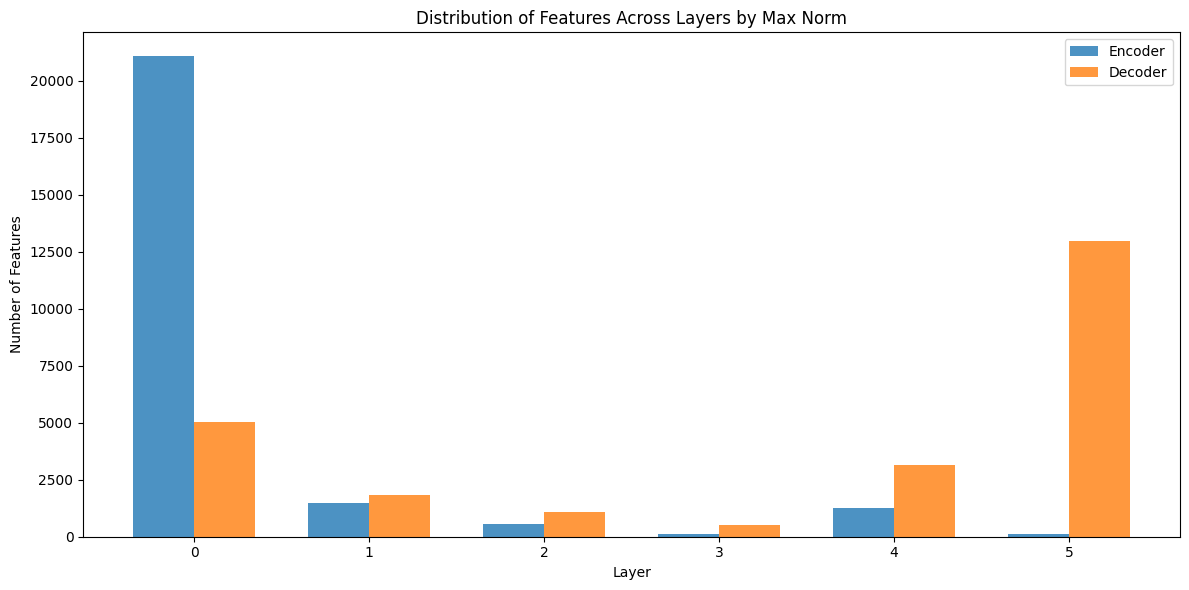

In [50]:
def bin_features_by_layer(feature_encoder_weights, feature_decoder_weights, num_layers):
    # Reshape the encoder and decoder weights to separate layers
    enc_w = feature_encoder_weights.reshape(feature_encoder_weights.shape[0], num_layers, -1)
    dec_w = feature_decoder_weights.reshape(feature_decoder_weights.shape[0], num_layers, -1)
    
    # Calculate norms for each layer
    enc_layer_norms = torch.norm(enc_w, dim=-1)
    dec_layer_norms = torch.norm(dec_w, dim=-1)
    
    # Find the layer with the maximum norm for each feature
    enc_max_norm_layers = torch.argmax(enc_layer_norms, dim=1)
    dec_max_norm_layers = torch.argmax(dec_layer_norms, dim=1)
    
    # Initialize lists to hold features for each layer
    enc_layer_features = [[] for _ in range(num_layers)]
    dec_layer_features = [[] for _ in range(num_layers)]
    
    # Bin features by their max norm layer
    for feature_idx, (enc_layer_idx, dec_layer_idx) in enumerate(zip(enc_max_norm_layers, dec_max_norm_layers)):
        enc_layer_features[enc_layer_idx.item()].append(feature_idx)
        dec_layer_features[dec_layer_idx.item()].append(feature_idx)
    
    # Convert lists to tensors
    enc_layer_features = [torch.tensor(features, device=feature_encoder_weights.device) for features in enc_layer_features]
    dec_layer_features = [torch.tensor(features, device=feature_decoder_weights.device) for features in dec_layer_features]
    
    return enc_layer_features, dec_layer_features

# Usage example:
num_layers = 6  # Adjust this based on your model's architecture
enc_binned_features, dec_binned_features = bin_features_by_layer(feature_encoder_weights, feature_decoder_weights, num_layers)

# Print summary
print("Encoder:")
for layer, features in enumerate(enc_binned_features):
    print(f"Layer {layer}: {len(features)} features")

print("\nDecoder:")
for layer, features in enumerate(dec_binned_features):
    print(f"Layer {layer}: {len(features)} features")

# Visualize the distribution
import matplotlib.pyplot as plt

enc_feature_counts = [len(features) for features in enc_binned_features]
dec_feature_counts = [len(features) for features in dec_binned_features]

plt.figure(figsize=(12, 6))
x = range(num_layers)
width = 0.35

plt.bar([i - width/2 for i in x], enc_feature_counts, width, label='Encoder', alpha=0.8)
plt.bar([i + width/2 for i in x], dec_feature_counts, width, label='Decoder', alpha=0.8)

plt.title("Distribution of Features Across Layers by Max Norm")
plt.xlabel("Layer")
plt.ylabel("Number of Features")
plt.legend()

plt.xticks(x)
plt.tight_layout()
plt.show()

Processing layers:   0%|          | 0/6 [00:00<?, ?it/s]

Processing layers: 100%|██████████| 6/6 [29:07<00:00, 291.21s/it]


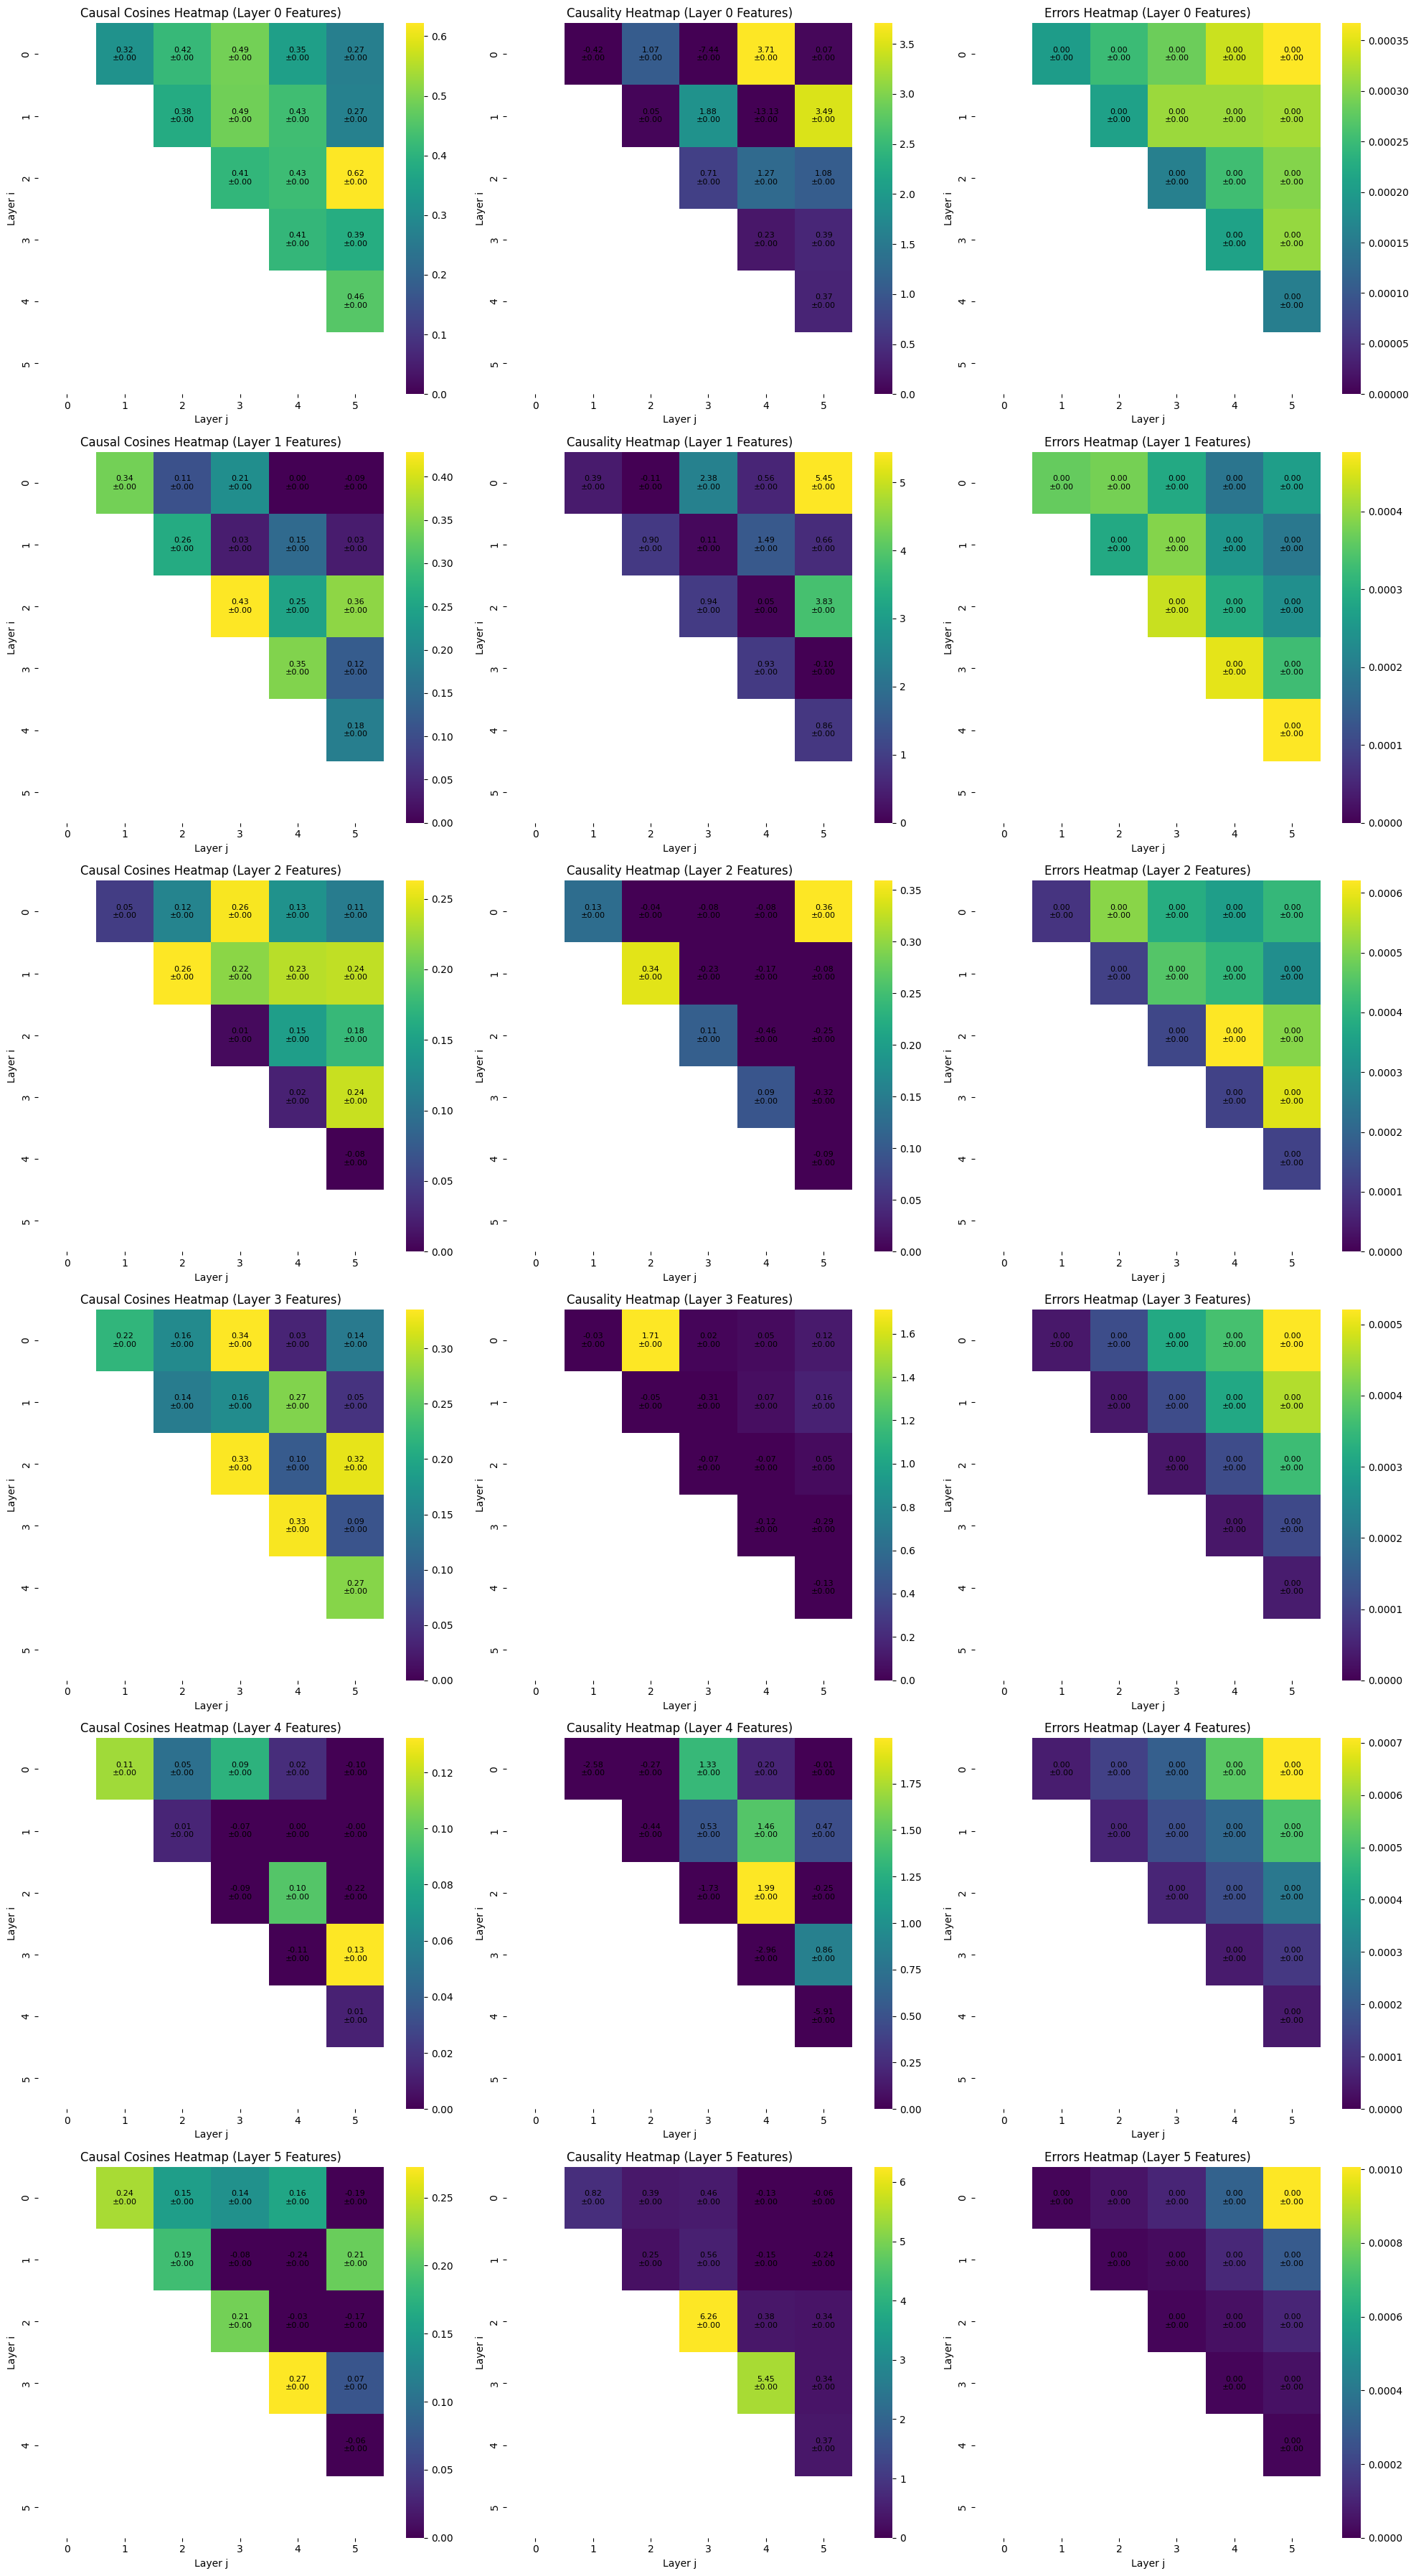

In [51]:
def run_layer_pair_evaluation_top_k(
    model,
    dataset,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    num_layers,
    binned_features,
    top_k=10,
    batch_size=128,
    lambda_value=1.0,
    num_tokens=1,
    exclude_first_k_tokens=0,
):
    results = {layer: {} for layer in range(num_layers)}

    for layer in tqdm(range(num_layers), desc="Processing layers"):
        layer_features = binned_features[layer]
        if len(layer_features) == 0:
            continue

        # Select top-k features based on their norms
        feature_norms = torch.norm(feature_encoder_weights[layer_features], dim=1)
        top_k_features = layer_features[
            torch.argsort(feature_norms, descending=True)[:top_k]
        ]

        for i in range(num_layers):
            for j in range(i + 1, num_layers):
                for feature_index in top_k_features:
                    causality, causal_cosines, errors, _, _, _, _, _, is_valid = (
                        compute_causal_attribution_strength(
                            j=i,
                            k=j,
                            model=model,
                            inputs={"input_ids": dataset["input_ids"].cuda()},
                            feature_encoder_weights=feature_encoder_weights,
                            feature_encoder_bias=feature_encoder_bias,
                            feature_decoder_weights=feature_decoder_weights,
                            lambda_value=lambda_value,
                            feature_select_k=None,
                            feature_select_percentile=None,
                            top_k_tokens=num_tokens,
                            exclude_first_k_tokens=exclude_first_k_tokens,
                            feature_indices=feature_index.item(),
                        )
                    )

                    # Filter out invalid items and compute mean
                    valid_causality = (
                        causality.mean().item() if is_valid.any() else np.nan
                    )
                    valid_causal_cosines = (
                        causal_cosines.mean().item() if is_valid.any() else np.nan
                    )
                    valid_errors = errors.mean().item() if is_valid.any() else np.nan

                    if (i, j) not in results[layer]:
                        results[layer][(i, j)] = {
                            "causality": [],
                            "causal_cosines": [],
                            "errors": [],
                        }

                    results[layer][(i, j)]["causality"].append(valid_causality)
                    results[layer][(i, j)]["causal_cosines"].append(
                        valid_causal_cosines
                    )
                    results[layer][(i, j)]["errors"].append(valid_errors)

        # Compute average for each metric
        for i, j in results[layer]:
            for metric in ["causality", "causal_cosines", "errors"]:
                results[layer][(i, j)][metric] = np.nanmean(
                    results[layer][(i, j)][metric]
                )

    return results


def plot_layer_heatmaps_top_k(results, num_layers):
    fig, axes = plt.subplots(num_layers, 3, figsize=(20, 6 * num_layers))

    for layer in range(num_layers):
        if not results[layer]:
            continue

        matrices = {
            "causal_cosines": np.zeros((num_layers, num_layers)),
            "causality": np.zeros((num_layers, num_layers)),
            "errors": np.zeros((num_layers, num_layers)),
        }
        std_matrices = {
            "causal_cosines": np.zeros((num_layers, num_layers)),
            "causality": np.zeros((num_layers, num_layers)),
            "errors": np.zeros((num_layers, num_layers)),
        }

        for (i, j), values in results[layer].items():
            for metric in matrices.keys():
                matrices[metric][i, j] = values[metric]
                std_matrices[metric][i, j] = np.std(values[metric])

        titles = ["Causal Cosines", "Causality", "Errors"]

        for col, (title, matrix) in enumerate(zip(titles, matrices.values())):
            ax = axes[layer, col] if num_layers > 1 else axes[col]

            # Create a mask for the lower triangle and diagonal
            mask = np.tril(np.ones_like(matrix, dtype=bool))

            sns.heatmap(
                matrix,
                ax=ax,
                cmap="viridis",
                cbar=True,
                annot=False,
                mask=mask,
                vmin=0,  # Set minimum value to 0
                vmax=np.nanmax(matrix),  # Set maximum value to the max of valid entries
            )

            # Add text annotations with mean and std only for upper triangle
            for i in range(num_layers):
                for j in range(i + 1, num_layers):
                    if not np.isnan(matrix[i, j]) and matrix[i, j] != 0:
                        text = f"{matrix[i, j]:.2f}\n±{std_matrices[title.lower().replace(' ', '_')][i, j]:.2f}"
                        ax.text(
                            j + 0.5, i + 0.5, text, ha="center", va="center", fontsize=8
                        )

            ax.set_title(f"{title} Heatmap (Layer {layer} Features)")
            ax.set_xlabel("Layer j")
            ax.set_ylabel("Layer i")

    plt.tight_layout()
    plt.show()


# Run the evaluation
num_layers = 6  # Adjust this based on your model's architecture
dataset_sample = tokenized.select(range(1000))  # Adjust sample size as needed

results = run_layer_pair_evaluation_top_k(
    model=model,
    dataset=dataset_sample,
    feature_encoder_weights=feature_encoder_weights,
    feature_encoder_bias=feature_encoder_bias,
    feature_decoder_weights=feature_decoder_weights,
    num_layers=num_layers,
    binned_features=enc_binned_features,  # Use enc_binned_features instead of binned_features
    top_k=10,
    batch_size=128,
    lambda_value=1.0,
    num_tokens=1,
    exclude_first_k_tokens=0,
)

# Plot the heatmaps
plot_layer_heatmaps_top_k(results, num_layers)